# **DCDC Práctica Final: Predicción de Stock<a id="top"></a>**

<i><small>**Alumnos:** Che Cui y Alejandro Pequeño<br>Última actualización: 15/01/2024</small></i></div>

Análisis y predicción de series de temporales de stock basadas en noticias para la asignatura de Descubrimineto de Conocimiento en Datos Complejos

El siguiente notebook, presentará el proceso de análisis de una serie temporal de los valores de la bolsa europea y un pipeline de predicción de los valores futuros de la misma, usando métodos desde AR hasta SARIMAX. Para la parte de predicción con variables exógenas. Para ello, usaremos un análisis de sentimiento de las noticias financieras incluido en el dataset de noticias de revistas francesas. Dicho dataset se puede encontrar en el siguiente enlace: [Dataset](https://www.kaggle.com/datasets/arcticgiant/french-financial-news).

Adicionalmente, se incluye un ánalisis de las revistas financieras francesas del dataset para intentar obtener las revistas más influentes en el mercado de valores europeo.

---

**Índice:**

- [Imports](#-Imports)


- [1. Dataset](##-1.-Dataset)
  - [1.1 Carga y visualización](###-1.1-Carga-y-visualización)
  - [1.2 Preprocesado](###-1.2-Preprocesado)

<lr>

- [2. Análisis del DataFrame](##-2.-Análisis-del-DataFrame)
  - [2.1 Descomposición de la serie temporal](###-2.1-Descomposición-de-la-serie-temporal)
  - [2.2 Prueba de Dickey-Fuller](###-2.2-Prueba-de-Dickey-Fuller)
  - [2.3 Análisis de la autocorrelación](###-2.3-Análisis-de-la-autocorrelación)

<lr>

- [3. Métodos de Predicción](#-3.-Métodos-de-Predicción)
  - [3.0 AR, MA, ARMA](###-3.1-AR,-MA,-ARMA)
  - [3.1 ARIMA](###-3.1-ARIMA)
  - [3.2 SARIMA](###-3.2-SARIMA)
  - [3.3 SARIMAX](###-3.3-SARIMAX)

<lr>


## Imports

In [1]:
# Imports
# =====================================================================
!pip install statsmodels
!pip install pandas-datareader
!pip install yfinance

import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import yfinance as yfin
import sklearn.preprocessing as preprocessing
import warnings
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import scipy.stats
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.filters.hp_filter import hpfilter
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.statespace.sarimax import SARIMAX

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## 1. Dataset

### 1.1 Carga y visualización

El dataset proviene de Kaggle. En ella contiene alrededor de 41500 noticias francesas que van desde 2017-10-19 hasta 2021-03-19. Son scrapeado en paginas webs de noticias financieras famosas.

In [2]:
# Abrimos el archivo en formato pandas Dataframe
# =====================================================================
warnings.filterwarnings("ignore")
# Vía local ======
news_french = pd.read_csv("./data/FrenchNews.csv", parse_dates=True,  sep=',') # lectura y preprocesado de datos

# Visualización de los datos
news_french # versión tabular

,Numero news,Numero page,Numero,Date,Heure,Titre,Contenu,Agency,URL,textURL,Nbr image,seconds to 2010,days to 2010,dateDT,Title eng,Content eng,textURL eng,Sentiment Vader Title,Sentiment Vader Text,Sentiment Vader TextURL
0,1,2127,18,19.10.2017,08:57,Marseille : une baleine de 15 mètres piégée da...,C'est une drôle de découverte qu'ont faite ce ...,Le Point,https://www.boursorama.com/actualite-economiqu...,C'est une drôle de découverte qu'ont faite ce ...,0,246099420.0,2848.372917,2017-10-19 08:57:00,Marseille: a 15 metre whale trapped in the Old...,This is a strange discovery that the Marseilla...,It's a strange discovery that the Marseillais ...,-0.5267,0.3612,0.8689
1,2,2127,17,19.10.2017,10:35,"Le Burkinabé qui a stoppé le désert, l'intox d...",L'émission de cette semaine nous emmène au Bur...,France 24,https://www.boursorama.com/videos/actualites/l...,L'émission de cette semaine nous emmène au Bur...,0,246105300.0,2848.440972,2017-10-19 10:35:00,"The Burkinabe who stopped the desert, the into...",This week's show takes us to Burkina Faso to m...,This week's show takes us to Burkina Faso to m...,-0.2263,-0.6486,-0.1531
2,3,2127,16,19.10.2017,10:59,"En Grande-Bretagne, les ventes au détail subis...",LONDRES (Reuters) - Les ventes au détail en Gr...,Reuters,https://www.boursorama.com/actualite-economiqu...,LONDRES (Reuters) - Les ventes au détail en Gr...,1,246106740.0,2848.457639,2017-10-19 10:59:00,"In Great Britain, retail sales stopped in Sept...",LONDON (Reuters) - Retail sales in Great Brita...,LONDON (Reuters) - Retail sales in Great Brita...,0.4939,0.3182,-0.4019
3,4,2127,15,19.10.2017,11:40,Antiterrorisme : Bruxelles fait avec les moyen...,La sécurité ne fait pas partie des prérogative...,Le Point,https://www.boursorama.com/actualite-economiqu...,La sécurité ne fait pas partie des prérogative...,0,246109200.0,2848.486111,2017-10-19 11:40:00,Anti-terrorism: Brussels made with the means o...,Security is not part of the European Union's p...,Security is not part of the European Union's p...,0.0000,0.3400,-0.9748
4,5,2127,14,19.10.2017,11:58,"Dmitri Rybolovlev, président de l'AS Monaco, i...","NICE (Reuters) - Le président de l'AS Monaco, ...",Reuters,https://www.boursorama.com/actualite-economiqu...,"NICE (Reuters) - Le président de l'AS Monaco, ...",1,246110280.0,2848.498611,2017-10-19 11:58:00,"Dmitri Rybolovlev, President of AS Monaco, cha...","NICE (Reuters) - The president of AS Monaco, D...","NICE (Reuters) - The president of AS Monaco, D...",-0.2023,-0.3954,0.9386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41538,41539,2,5,19.03.2021,08:44,Chine: des véhicules de police arrivent au tri...,Des véhicules de police aux vitres teintées ce...,AFP Video,https://www.boursorama.com/videos/actualites/c...,Des véhicules de police aux vitres teintées ce...,0,353839440.0,4095.363889,2021-03-19 08:44:00,"China: Police vehicles arrive in court, Canadi...",Police vehicles with tinted windows supposed t...,Police vehicles with tinted windows supposed t...,0.0000,-0.8807,-0.8807
41539,41540,2,4,19.03.2021,08:45,Des voitures de police quittent le tribunal ch...,Des voitures de police qui transporteraient le...,AFP Video,https://www.boursorama.com/videos/actualites/d...,Des voitures de police qui transporteraient le...,0,353839500.0,4095.364583,2021-03-19 08:45:00,Police cars leave the Chinese court while the ...,Police cars transporting the Canadian on charg...,Police cars that would transport the Canadian ...,-0.0516,-0.3182,-0.3182
41540,41541,2,3,19.03.2021,08:49,Confinement: les coiffeurs pourront rester ou...,Les coiffeurs dans les zones concernées par un...,AFP,https://www.boursorama.com/actualite-economiqu...,Les coiffeurs dans les zones concernées par un...,0,353839740.0,4095.367361,2021-03-19 08:49:00,"Confection: hairdressers can stay open, says G...",The hairdressers in the areas affected by a ne...,"In the area concerned by a new confinement, th...",0.0000,0.3612,0.7558
41541,4

Como se puede observar a simple vista, el dataset contiene 20 columnas, de las cuales solo nos interesan las columnas de fecha y noticias con el fin de realizar un análisis de series temporales. Para ello, pasamos a preprocesar el dataset.

### 1.2 Preprocesado

#### 1.2.1 Preprocesado de los datos del dataset

**Selección de columnas:** Elegimos las columnas de fecha y el contenido de las noticias. Con esto, podemos hacer un análisis de sentimiento de las noticias y ver si hay alguna correlación con el precio de las acciones.

In [3]:
# Seleccionamos las clomnas de fecha y contenido de la noticia
news = news_french[['Date', 'Contenu']].copy()
news['Date'] = pd.to_datetime(news['Date'], format='%d.%m.%Y') # pasamos las fechas a formato datetime

# renombramos las columnas para que sean más faciles de manejar
news.rename(columns={'Contenu': 'headline', 'Date': 'date'}, inplace=True)

**Comprobación de valores nulos**: Comprobamos si hay valores nulos en las columnas seleccionadas. En este caso, no observamos que para las fechas no haya ningún valor nulo, pero para el contenido de las noticias sí que hay 65 valores nulos. Por ello, al tener 41543 noticias, decidimos eliminar las 65 noticias que no tienen contenido.

In [4]:
# Comprobación de valores nulos
news.isnull().sum()

date         0
headline    65
dtype: int64

In [5]:
# Eliminamos los valores nulos del dataset (aunque lo hagamos globalmente solo afectará a la columna de headline ya que es la única que tiene valores nulos)
news.dropna(inplace=True)

#### 1.2.2 Prepraración de los datos de stock

Con la ayuda de las librería de pandas-datareader e yfinance, es posible saca de manera facil desde Yahoo Finance los datos de los stock de manera facil y sencilla.

In [6]:
# la fecha mínima y máxima de las noticias
min_date = news.date.min()
max_date = news.date.max()

# =====================================================================
min_date = min_date
# son las fechas que intentaremos predecir
max_date = max_date + pd.DateOffset(days=50)

# convertimos las fechas a string
min_date = min_date.strftime('%Y-%m-%d')
max_date = max_date.strftime('%Y-%m-%d')

In [7]:
yfin.pdr_override()
# datos del índice europeo
euro = pdr.get_data_yahoo('^STOXX50E', start=min_date, end=max_date)

[*********************100%%**********************]  1 of 1 completed


In [8]:
# datos del índice europeo
display(euro)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-10-19,3616.489990,3616.489990,3586.350098,3602.080078,3602.080078,35701200
2017-10-20,3608.750000,3617.520020,3600.050049,3605.090088,3605.090088,34868200
2017-10-23,3606.709961,3625.649902,3597.080078,3608.870117,3608.870117,25744300
2017-10-24,3606.639893,3624.729980,3605.030029,3610.689941,3610.689941,32719500
2017-10-25,3609.020020,3622.620117,3585.320068,3591.459961,3591.459961,33992400
...,...,...,...,...,...,...
2021-05-03,3979.500000,4009.729980,3965.500000,4000.250000,4000.250000,20815100
2021-05-04,4001.129883,4018.139893,3919.459961,3924.800049,3924.800049,35163600
2021-05-05,3927.290039,4003.090088,3927.290039,4002.790039,4002.790039,30131400


In [9]:
# solo nos interesa predecir el valor de apertura
euro_open = euro[['Open']].copy()

# # reseteamos el índice
# euro_open.reset_index(inplace=True)

# # normalizamos los datos para que estén entre 0 y 1
# min_max_scaler = preprocessing.MinMaxScaler()
# euro_open['Open'] = min_max_scaler.fit_transform(euro_open['Open'].values.reshape(-1,1))

# datos final
euro_open

,Open
Date,
2017-10-19,3616.489990
2017-10-20,3608.750000
2017-10-23,3606.709961
2017-10-24,3606.639893
2017-10-25,3609.020020
...,...
2021-05-03,3979.500000
2021-05-04,4001.129883
2021-05-05,3927.290039


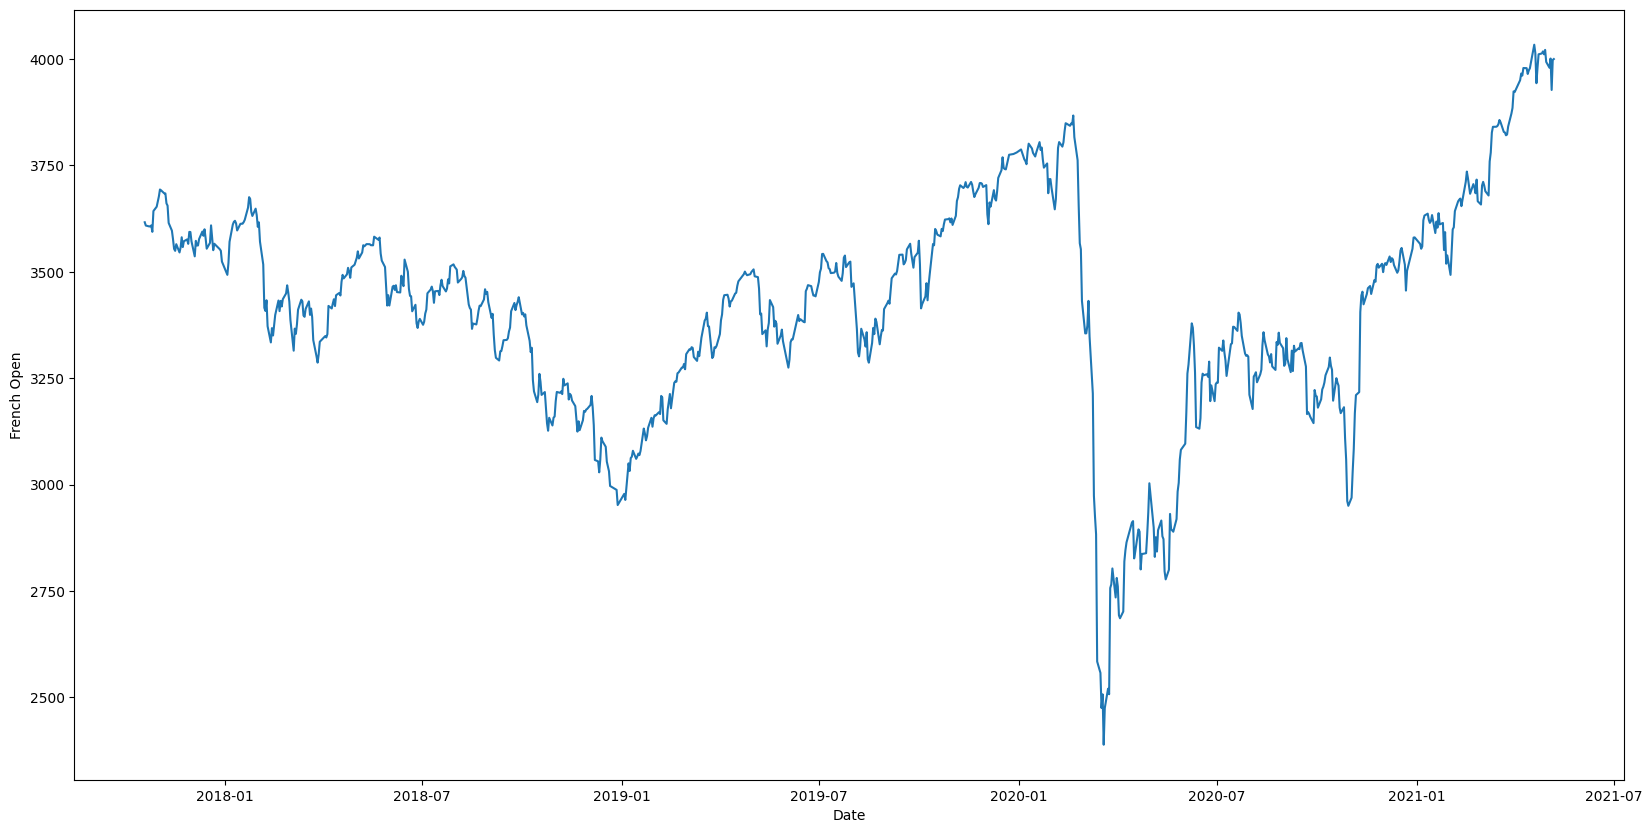

In [10]:
# plot euro open using the date as x-axis
plt.figure(figsize=(20,10))
plt.plot(euro_open['Open'])
plt.xlabel('Date')
plt.ylabel('French Open')
plt.savefig('euro_open.png')
plt.show()

## 2. Análisis del DataFrame

### 2.1 Descomposición de la serie temporal

1. **Descomposición Aditiva**:
   - Los datos originales se descomponen en componentes aditivos, que incluyen tendencia, estacionalidad y residuos.
   - Los residuos del modelo aditivo muestran patrones que se suman de manera constante. Si estos residuos aumentan con el tiempo, esto podría indicar una tendencia creciente en la variabilidad de los datos.

2. **Descomposición Multiplicativa**:
   - Los datos originales se descomponen en componentes multiplicativos, que también incluyen tendencia, estacionalidad y residuos.
   - Elmodelo multiplicativo, los residuos son más constantes, y cualquier patrón de aumento se vería como una variabilidad proporcional. Un aumento constante en los residuos podría sugerir un aumento constante en la variabilidad relativa a la tendencia y la estacionalidad.

**Conclusión:**
- En la serie temporal los residuos aumentan de manera aditiva, mientras que en el enfoque multiplicativo los residuos se mantienen constantes, se podría concluir que la serie es más probablemente multiplicativa. Sin embargo, es importante realizar pruebas y validar el modelo para confirmar la elección del enfoque.

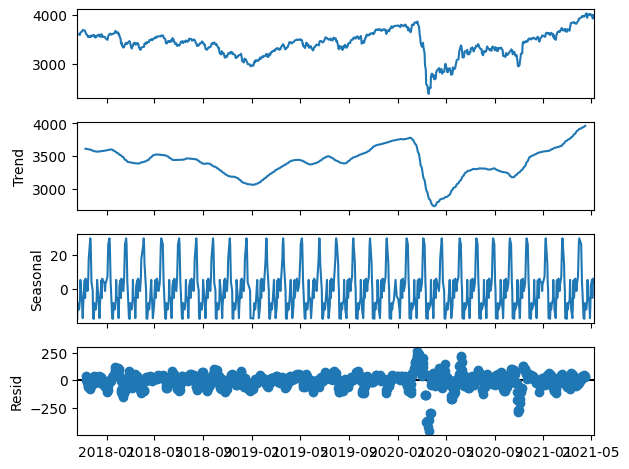

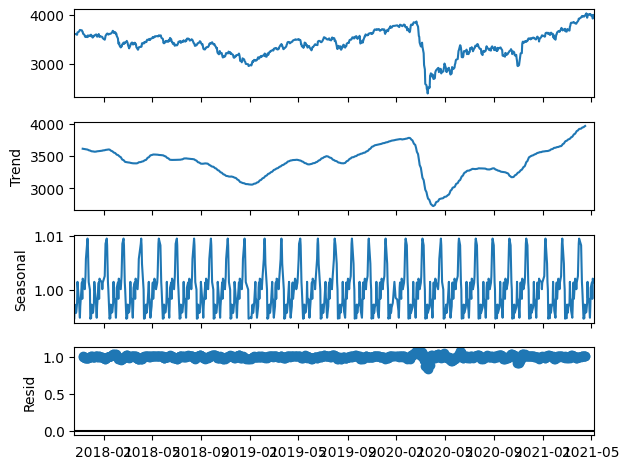

In [11]:
# Descomposición de la serie temporal
# =====================================================================

# Aditiva
result = seasonal_decompose(euro_open, model='additive', period = 30)
result.plot()
plt.show()

# Multiplicativa
result = seasonal_decompose(euro_open, model='multiplicative', period = 30)
result.plot()
plt.show()

### 2.2 Prueba de Dickey-Fuller

Como podemos observar, tras la prueba de dickey-fuller, la serie no se puede decir que es estacionaria. Esto lo podemos deducir del valor del estadístico de prueba (ADF estadístico) y el p-valor junto con la comparación de estos valores con los valores críticos. En este caso, el valor del estadístico de prueba es positivo (0.8153688792060498) y mayor que los valores críticos en diferentes niveles de significación (1%, 5%, 10%). Además, el valor p es alto (0.991880243437641), lo que indica que no podemos rechazar la hipótesis nula de que la serie no es estacionaria.

En resumen, la serie temporal no es estacionaria según los resultados de la prueba de Dickey-Fuller.

In [12]:
# Prueba de dickey-fuller
# =====================================================================
sts.adfuller(euro_open.Open) # p-value > 0.05, no se puede rechazar la hipótesis nula de que la serie temporal no es estacionaria

(-2.4006037122225927,
 0.14156608787186625,
 9,
 878,
 {'1%': -3.437819842246547,
  '5%': -2.8648374649929753,
  '10%': -2.5685258078777093},
 8649.705863031279)

Debido a la no estacionalidad de los valores de la serie, probamos a hacer su integración para representar la serie de una manera de variación porcentual con respecto a los días anteriores, lo cual puede dar un análisis más completo y para ver si podemos conseguir por lo menos que esta parte sea estacionaria para poder hacer un mejor estudio de la serie, pues la estacionalidad de una serie (media y desviación típica constantes) hará que podamos hacer un mejor análisis de esta, pues existirá una relación directa (autocorrelación, dependencia) entre los elementos futuros de la serie con los elementos pasados, además de que los errores son prácticamente cte. y, por tanto, previsibles.

La prueba de Dickey-Fuller con los retornos de la serie, los resultados de la prueba de Dickey-Fuller sugieren que es estacionaria, ya que el p valor es menor que 0.05 y el estadístico de prueba es negativo y menor que los valores críticos en el nivel de significación del 5% (aunque mayor que el 1%).

In [13]:
# Calculamos los retornos del dataset y hacemos también la prueba de dickey-fuller
# =====================================================================
euro_open['Returns'] = euro_open.Open.pct_change(1).mul(100) # returns in percentage (variación porcentual con respecto al mes anterior)
sts.adfuller(euro_open.Returns[1:]) # p-value < 0.05, se rechaza la hipótesis nula de que la serie temporal no es estacionaria

(-9.681938731506397,
 1.198177289266378e-16,
 8,
 878,
 {'1%': -3.437819842246547,
  '5%': -2.8648374649929753,
  '10%': -2.5685258078777093},
 2657.4506823890306)

In [14]:
# Calculamos los retornos del dataset y hacemos también la prueba de dickey-fuller
# =====================================================================
euro_open['Returns_Returns'] = euro_open.Returns.pct_change(1).mul(100) # returns in percentage (variación porcentual con respecto al mes anterior)
sts.adfuller(euro_open.Returns_Returns[2:]) # p-value < 0.05, se rechaza la hipótesis nula de que la serie temporal no es estacionaria

(-29.687596079000773,
 0.0,
 0,
 885,
 {'1%': -3.437760586044626,
  '5%': -2.8648113393251466,
  '10%': -2.5685118915381913},
 16946.066841327534)

### 2.3 Análisis de la autocorrelación

En ambos casos, optaremos por seleccionar un rezago temporal (lag) de 24 unidades, dado que al abordar el número de pasajeros por mes, la consideración de un período de análisis de 2 años (24 meses) puede conferir mayor representatividad a la serie temporal.

- Mediante el análisis de autocorrelación de la serie de pasajeros, se aprecia que, a nivel global (ACF), la influencia preponderante en el número de pasajeros de un mes específico proviene del mes inmediatamente anterior. Aunque se puede observar un patrón sugerente de 12 meses, reflejado en la evolución de la autocorrelación a lo largo de los 24 lags, indicando que la serie podría estar influenciada significativamente por los últimos 12 meses. Por otro lado, en el análisis a nivel parcial (PACF), revela que la serie se ve afectada tanto por el mes anterior como por el mes del año anterior, es decir, el mes 12.

  Por ejemplo, el ACF y el PACF indican que el número de pasajeros en un mes determinado se encuentra influido tanto por el mes precedente como por el mismo mes del año anterior (mes 12).

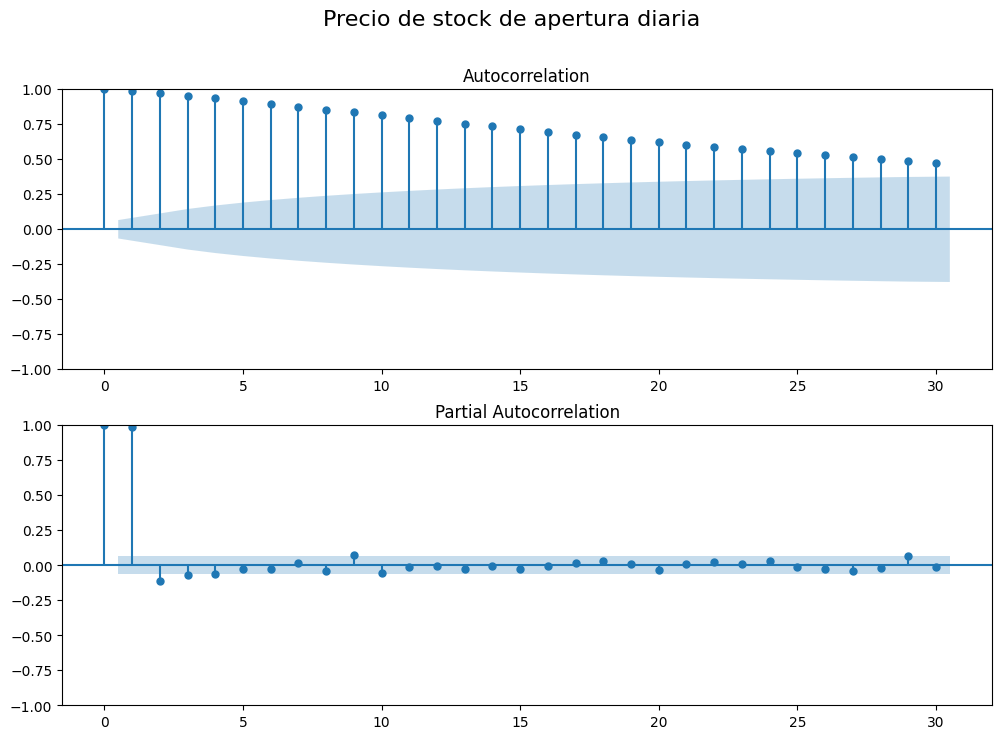

In [15]:
# Análisis de la autocorrelación de los pasajeros mensuales
# =====================================================================
def plot_acf_pacf(df, lags, title):
    fig, ax = plt.subplots(2,1,figsize=(12,8))
    plt.suptitle(title, fontsize=16)
    sgt.plot_acf(df, lags = lags, ax=ax[0]) # autocorrelación
    sgt.plot_pacf(df, lags = lags, ax=ax[1]) # autocorrelación parcial
    plt.show()


plot_acf_pacf(euro_open.Open,lags=30, title='Precio de stock de apertura diaria')

- El análisis de autocorrelación para los retornos de los pasajeros muestra algo similar al de los pasajeros, pero más marcado, indicando que la serie se ve influencia por los valores de los 12 y 24 últimos meses y a nivel parcial solo cada 12 meses.

  Al realizar el análisis de autocorrelación de los retornos de los pasajeros, se observa una similitud con la serie de pasajeros, aunque con una marcada intensificación. A nivel global (ACF), se aprecia una relación significativa con los últimos 12 y 24 meses, indicando una influencia persistente a lo largo de estos períodos. En el análisis a nivel parcial (PACF), se revela que la serie de retornos se ve afectada principalmente cada 12 meses.

  Este patrón refleja una dependencia significativa en los últimos dos años, señalando que los retornos de un mes dado se ven afectados por los valores de los dos años anteriores y a nivel individual por el mes del año anterior. La presencia de correlaciones persistentes cada 12 meses en el análisis a nivel parcial refuerza la idea de que la serie de retornos exhibe una estructura estacional anual.

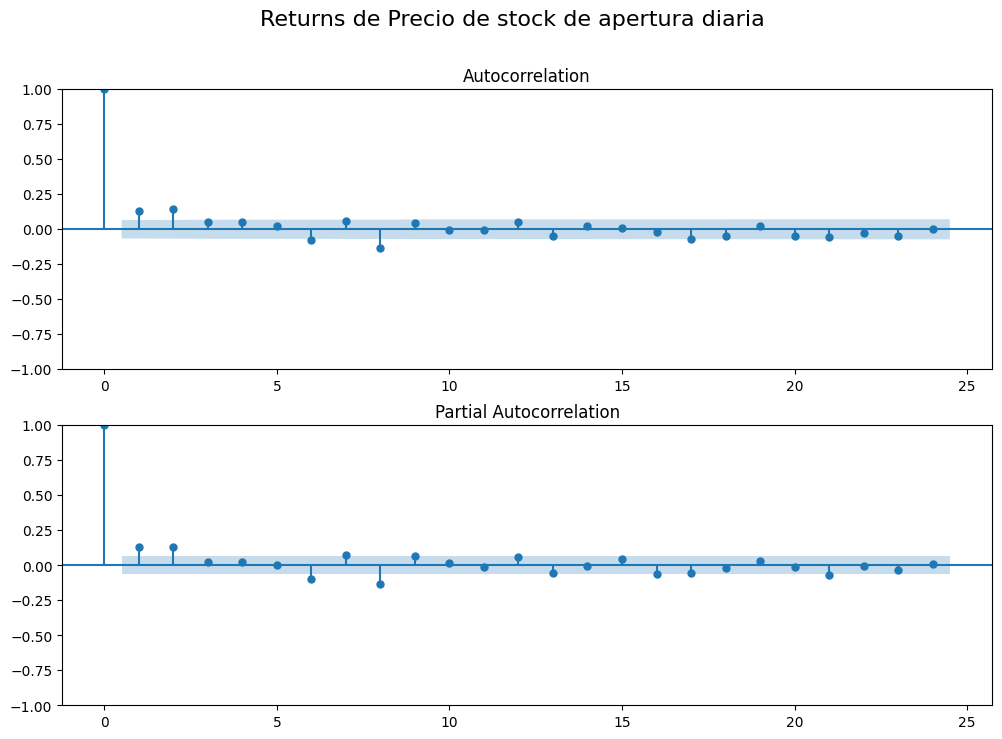

In [16]:
# Análisis de la autocorrelación del retorno pasajeros mensuales
# =====================================================================
plot_acf_pacf(euro_open.Returns[1:],lags=24, title='Returns de Precio de stock de apertura diaria')

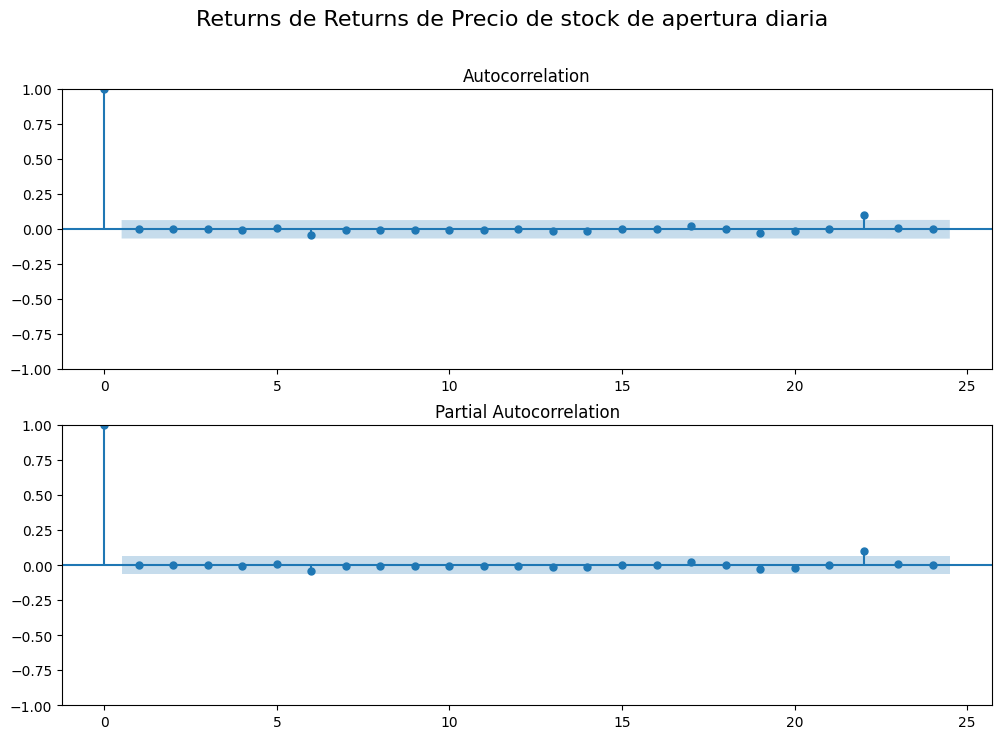

In [17]:
# Análisis de la autocorrelación del retorno pasajeros mensuales
# =====================================================================
plot_acf_pacf(euro_open.Returns_Returns[2:],lags=24, title='Returns de Returns de Precio de stock de apertura diaria')

## 3. Métodos de Predicción

In [18]:
# División de los datos en train y test
# =====================================================================
size = len(euro_open) - 50
wd_train, wd_test = euro_open.iloc[:size], euro_open.iloc[size:]

### 3.0 AR, MA, ARMA

Antes de pasar a los modelos de la práctica, vamos a realizar un análisis de los modelos AR, MA y ARMA para poder usar estos modelos como base para los modelos ARIMA, SARIMA y SARIMAX y elegir sus hiperparámetros. Para ello, usaremos la primera serie estacionaria (retornos de la serie de pasajeros).

#### 3.0.1 AR

- El modelo AR, se trata de un modelo autorregresivo, es decir, un modelo que predice el valor futuro de una variable en función de sus valores pasados. En este caso, el modelo AR se basa en la regresión lineal de la variable dependiente (y) con respecto a sus valores pasados (y(t-1), y(t-2), ...), es decir, la variable dependiente se regresa a sí misma.

In [19]:
# AR
# =====================================================================
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa import ar_model

# AIC
ARfitAIC = ar_model.ar_select_order(wd_train.Returns[1:],17, ic="aic", glob=True)
orden=ARfitAIC.ar_lags # orden del modelo
print(f'Lag: {orden}')

Lag: [1, 2, 4, 6, 7, 8, 9, 12, 13, 15, 16, 17]


In [20]:
from sklearn.metrics import mean_squared_error
import pandas as pd

testGeneral = [1, 2, 4, 6, 7, 8, 9, 12, 13, 15, 16, 17] # elegimos los lags que nos interesan

ModelArima = {}

llf_list = []
aic_list = []
bic_list = []
error_list = []

for x in testGeneral:
  model_ar = ARIMA(wd_train.Returns[1:], order=(x,0,0))
  results_ar = model_ar.fit()
  results_arfore = results_ar.forecast(steps=len(wd_test.Returns))
  ModelArima["AR("+str(x)+")"] = results_arfore

  error = mean_squared_error(wd_test.Returns, results_arfore)

  llf_list.append(results_ar.llf)
  aic_list.append(results_ar.aic)
  bic_list.append(results_ar.bic)
  error_list.append(error)

#########LO HE HECHO CON PLOTS PUES SI NO ME SALIAN LOS VALORES ENTREMIAS DE LOS AVISOS DEL OUTPUT DE ESTA CELDA Y NO SE VEIA MUY CLATO PARA HACER UN ANALISIS DE LOS RESULTADOS#########

# LLF -> Log Likelihood Function, represents the log of the likelihood function so the higher the LLF the better the model is
print("LLF")
for i in range(len(testGeneral)):
  print(f'AR({testGeneral[i]}): {llf_list[i]}')
  
print()

# AIC -> represents the tradeoff between the goodness of fit of the model and the simplicity of the model so the lowest AIC is chosen the better the model is
print("AIC")
for i in range(len(testGeneral)):
  print(f'AR({testGeneral[i]}): {aic_list[i]}')
  
print()

# BIC -> is a criterion for model selection among a finite set of models; the model with the lowest BIC is preferred
print("BIC")
for i in range(len(testGeneral)):
  print(f'AR({testGeneral[i]}): {bic_list[i]}')
  
print()

# Error -> the lower the error the better the model is
print("Error")
for i in range(len(testGeneral)):
  print(f'AR({testGeneral[i]}): {error_list[i]}')
  
print()

LLF
AR(1): -1304.303618041291
AR(2): -1296.8054348209037
AR(4): -1296.359766066259
AR(6): -1292.1748175235894
AR(7): -1289.6163792452219
AR(8): -1281.593709367744
AR(9): -1279.2108583038369
AR(12): -1277.3738702329022
AR(13): -1276.0125991381876
AR(15): -1274.9857413606524
AR(16): -1272.7244304795076
AR(17): -1271.5784462660872

AIC
AR(1): 2614.607236082582
AR(2): 2601.6108696418073
AR(4): 2604.719532132518
AR(6): 2600.3496350471787
AR(7): 2597.2327584904438
AR(8): 2583.187418735488
AR(9): 2580.4217166076737
AR(12): 2582.7477404658043
AR(13): 2582.0251982763752
AR(15): 2583.9714827213047
AR(16): 2581.4488609590153
AR(17): 2581.1568925321744

BIC
AR(1): 2628.7967082940504
AR(2): 2620.5301659237653
AR(4): 2633.098476555455
AR(6): 2638.1882276110946
AR(7): 2639.801175124849
AR(8): 2630.4856594403827
AR(9): 2632.449781383058
AR(12): 2648.965277452657
AR(13): 2652.9725593337175
AR(15): 2664.378491919626
AR(16): 2666.585694227826
AR(17): 2671.0235498714746

Error
AR(1): 0.5655049445048511
AR

- Basándonos en estos valores, podemos ver que los mejores modelos son los de AR(1), AR(2) y AR(8) pues son los que tienen menor error, AIC, BIC y mayor LLF. De entre estos modelos, el que tiene menor error es el AR(13), pero antes de elegir un único valor, veamos un plot para decidirnos.

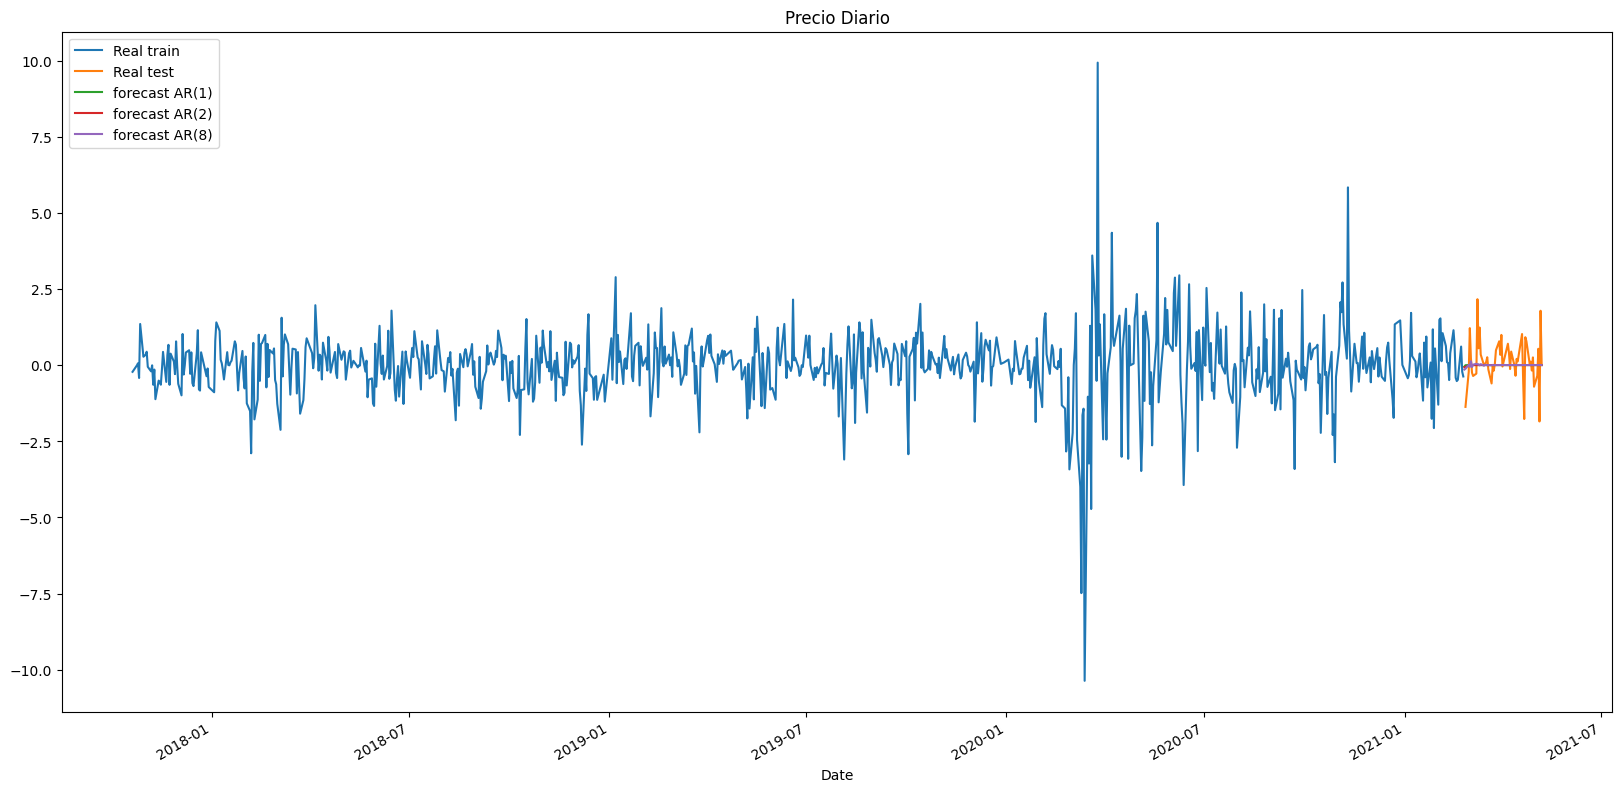

In [21]:
testGeneral = [1,2,8] # elegimos los lags que nos interesan con menor LLF, AIC, BIC y error

wd_train.Returns.plot(figsize=(20,10), title = "Precio Diario", label='Real train') # hacemos el plot de los datos de entrenamiento ajustado para que se vea mejor
wd_test.Returns[1:].plot(label='Real test')

for x in testGeneral:
   ModelArima["AR("+str(x)+")"].index=wd_test.Returns.index
   ModelArima["AR("+str(x)+")"].plot(label='forecast AR('+str(x)+")")
plt.legend(loc="upper left")

plt.show()

- Elección del modelo AR(1) para la predicción de la serie de pasajeros.

  - **AR(1)**: El modelo AR(1) tiene el menor error de entre todos tiniendo el resto de valores (LLF, AIC y BIC) muy similares a los del resto de modelos, por lo que elegiremos este modelo para predecir los valores de la serie. Y además como podemos observar es el que más se acercaba a los valores reales de la serie manreninedo un buen trade-off entre el error y la complejidad del modelo.

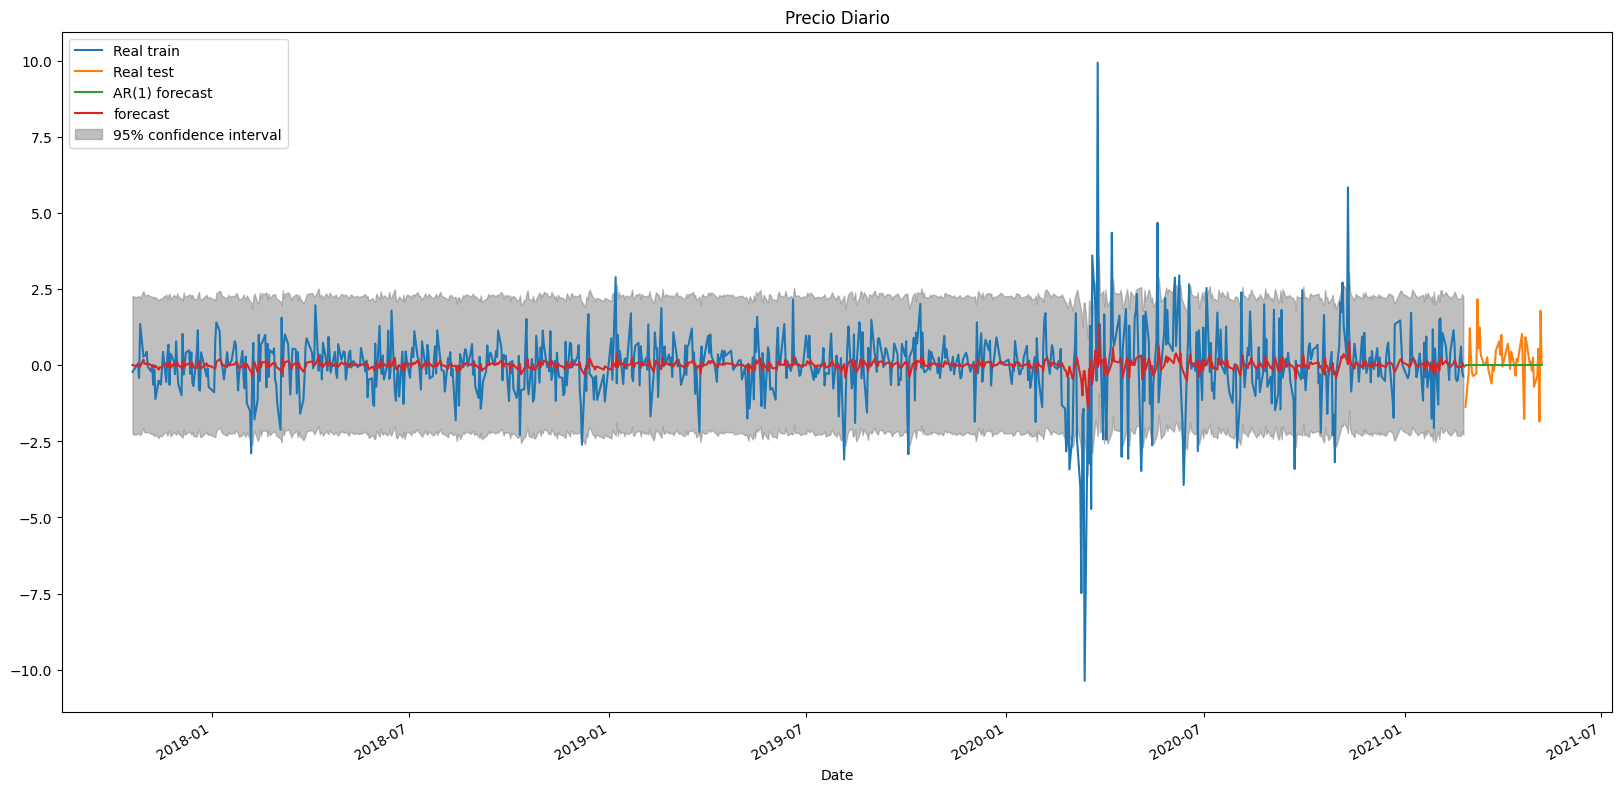

In [22]:
# AR(1) aunque 2 tmb estaba bien
# =====================================================================

# Plot adjusts
fig, ax = plt.subplots()
ax = wd_train.Returns[1:].plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real train')
ax = wd_test.Returns[1:].plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real test')

# AR(13)
model_ar = ARIMA(wd_train.Returns[1:], order=(1,0,0)) # elegimos el modelo con menor LLF, AIC, BIC y error, en este caso AR(13)
results_ar = model_ar.fit()
results_arfore = results_ar.forecast(steps=50)
results_arfore.index=wd_test.Returns.index

# Plot
ax = results_arfore.plot(ax=ax, label='AR(1) forecast')
plot_predict(results_ar, dynamic=False,ax=ax)
plt.legend(loc="upper left")
plt.show()

- Como podemos observar, el modelo AR(1) se ajusta bastante bien a los valores reales de la serie, pues el error es bastante bajo y el modelo se ajusta bastante bien a los valores reales de la serie. Por lo que tanto teóricamente c0mo visualmente, podemos decir que el modelo AR(1) es un buen modelo para predecir los valores de la serie.

In [23]:
# Latent Likelihood Ratio
from scipy.stats.distributions import chi2
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

In [24]:
# MA
# =====================================================================
from sklearn.metrics import mean_squared_error

ModelArima=dict()
results_maprey=None

llf_list = []
aic_list = []
bic_list = []
error_list = []

testGeneral = range(25)

for x in testGeneral:
  model_ma = ARIMA(wd_train.Returns[1:], order=(0,0,x))
  results_ma = model_ma.fit()
  results_mafore = results_ma.forecast(steps=len(wd_test.Returns))
  ModelArima["MA("+str(x)+")"] = results_mafore

  error = None
  if results_maprey is not None:
    error = str(LLR_test(results_maprey, results_ma))

  results_maprey=results_ma
  
  llf_list.append(results_ma.llf)
  aic_list.append(results_ma.aic)
  bic_list.append(results_ma.bic)
  error_list.append(error)

#########LO HE HECHO CON PLOTS PUES SI NO ME SALIAN LOS VALORES ENTREMIAS DE LOS AVISOS DEL OUTPUT DE ESTA CELDA Y NO SE VEIA MUY CLATO PARA HACER UN ANALISIS DE LOS RESULTADOS#########

# LLF -> Log Likelihood Function, represents the log of the likelihood function so the higher the LLF the better the model is
print("LLF")
for i in range(len(testGeneral)):
  print(f'AR({testGeneral[i]}): {llf_list[i]}')
  
print()

# AIC -> represents the tradeoff between the goodness of fit of the model and the simplicity of the model so the lowest AIC is chosen the better the model is
print("AIC")
for i in range(len(testGeneral)):
  print(f'AR({testGeneral[i]}): {aic_list[i]}')
  
print()

# BIC -> is a criterion for model selection among a finite set of models; the model with the lowest BIC is preferred
print("BIC")
for i in range(len(testGeneral)):
  print(f'AR({testGeneral[i]}): {bic_list[i]}')
  
print()

# LLR test p-vaue -> the lower the error the better the model is
print("LLR test p-vaue")
for i in range(len(testGeneral)):
  print(f'AR({testGeneral[i]}): {error_list[i]}')

LLF
AR(0): -1311.8131720683828
AR(1): -1305.9275203784805
AR(2): -1298.2350387755473
AR(3): -1297.6533667743413
AR(4): -1295.1104496563348
AR(5): -1295.0556906065772
AR(6): -1293.5606611487233
AR(7): -1290.5885041071365
AR(8): -1278.9620833749977
AR(9): -1278.1319688696865
AR(10): -1277.7994885148612
AR(11): -1277.7984540407665
AR(12): -1276.8309735834393
AR(13): -1275.935614849006
AR(14): -1275.6413290951407
AR(15): -1275.603772242537
AR(16): -1275.5655686986615
AR(17): -1272.4060214609876
AR(18): -1271.9668480197379
AR(19): -1271.2147777047135
AR(20): -1270.8521948845091
AR(21): -1270.6178357074846
AR(22): -1270.195874232752
AR(23): -1269.608827928761
AR(24): -1268.4421512030538

AIC
AR(0): 2627.6263441367655
AR(1): 2617.855040756961
AR(2): 2604.4700775510946
AR(3): 2605.3067335486826
AR(4): 2602.2208993126696
AR(5): 2604.1113812131543
AR(6): 2603.1213222974466
AR(7): 2599.177008214273
AR(8): 2577.9241667499955
AR(9): 2578.263937739373
AR(10): 2579.5989770297224
AR(11): 2581.59690808

- Basándonos en estos valores, podemos ver que los mejores modelos son los de MA(1-7) pues son los que tienen mejor equilibrio de menor error, AIC, BIC y mayor LLF.

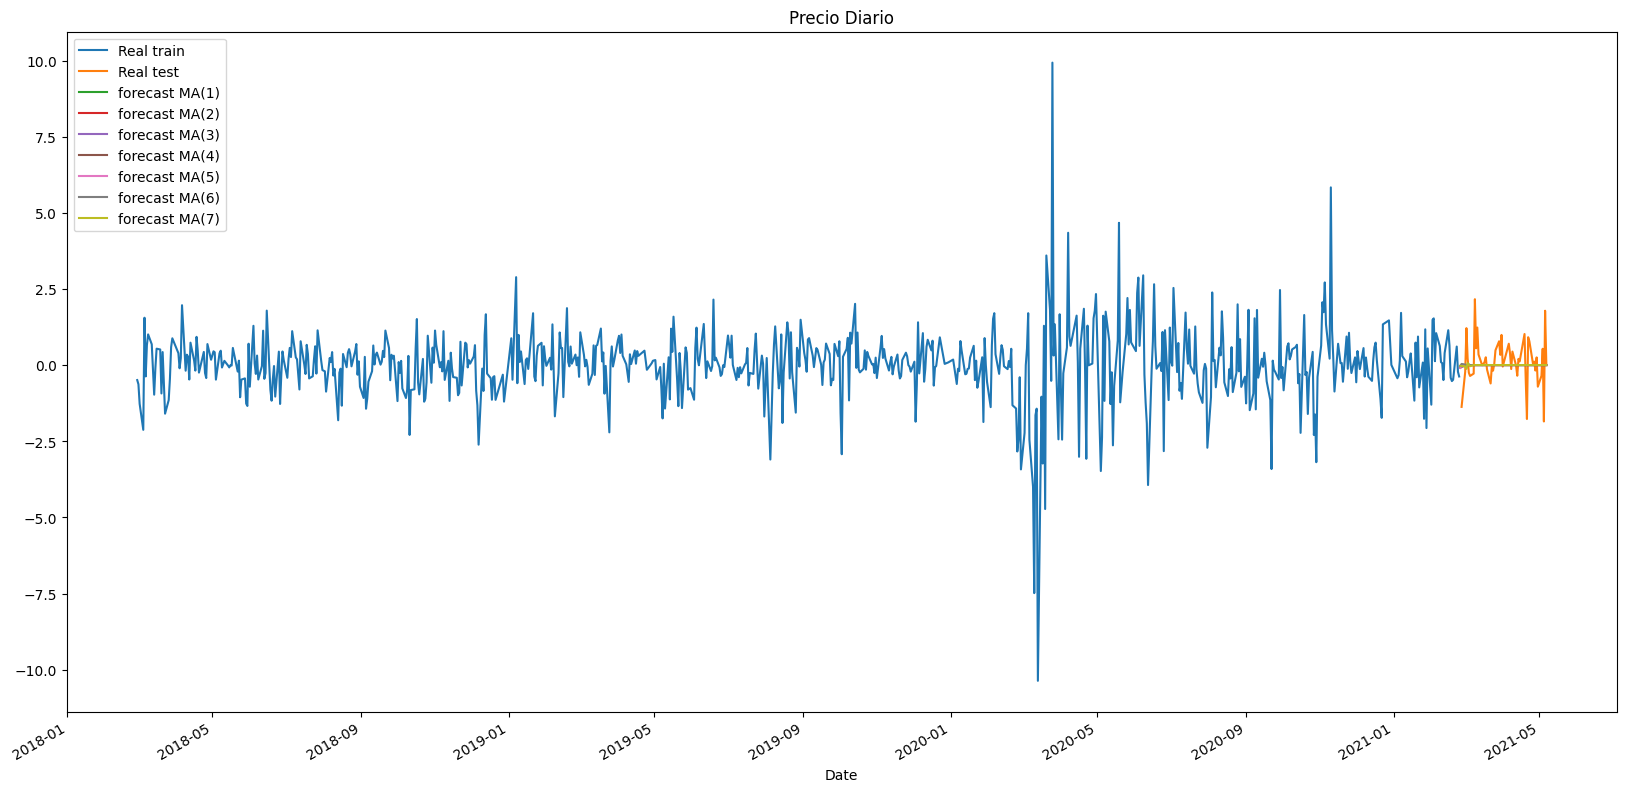

In [25]:
testGeneral = [1,2,3,4,5,6,7] # elegimos los lags que nos interesan con menor LLF, AIC, BIC y error

wd_train.Returns[90:].plot(figsize=(20,10), title = "Precio Diario", label='Real train')
wd_test.Returns[1:].plot(label='Real test')
for x in testGeneral:
   ModelArima["MA("+str(x)+")"].index=wd_test.Returns.index
   ModelArima["MA("+str(x)+")"].plot(label='forecast MA('+str(x)+")")
plt.legend(loc="upper left")
plt.show()

- Tras ver los resultados, vemos que el modelo MA(24) es el que visualmente se ve mejor y además tiene un LLF alto, menor error, AIC y BIC con respecto a los otros MA, por lo que elegiremos este modelo para predecir los valores de la serie.

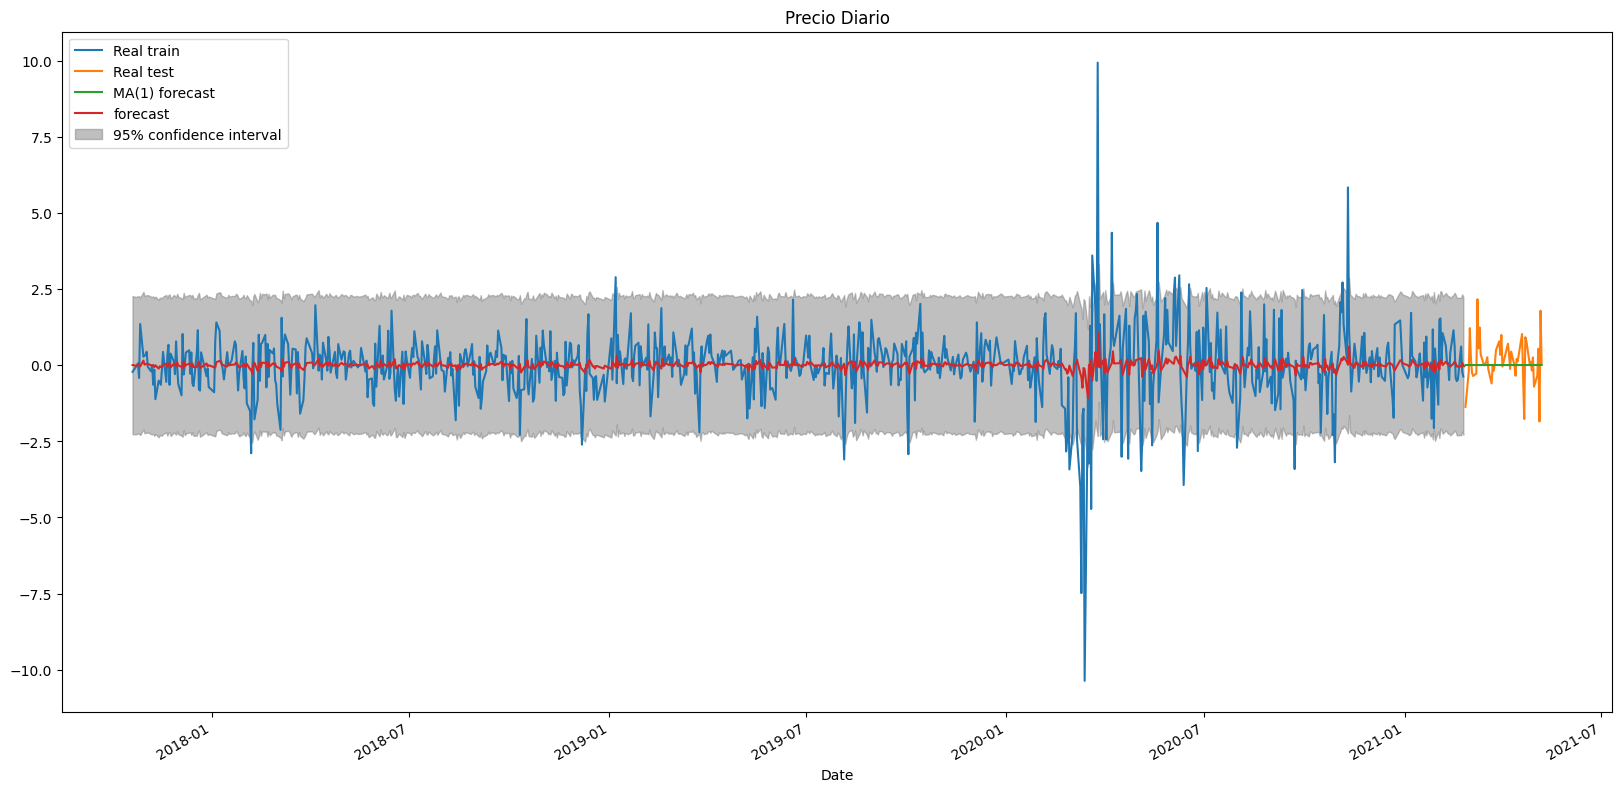

In [26]:
# MA(24)
# =====================================================================

# Plot adjusts
fig, ax = plt.subplots()
ax = wd_train.Returns[1:].plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real train')
ax = wd_test.Returns[1:].plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real test')

model_ma = ARIMA(wd_train.Returns[1:], order=(0,0,1)) # elegimos el modelo con menor LLF, AIC, BIC y error, en este caso MA(22)
results_ma = model_ma.fit()
results_mafore = results_ma.forecast(steps=50)
results_mafore.index=wd_test.Returns.index

# Plot
ax = results_mafore.plot(ax=ax,label='MA(1) forecast')
plot_predict(results_ma, dynamic=False,ax=ax)
plt.legend(loc="upper left")
plt.show()

- Vemos que los resultados son bastante buenos, pues el LLF es alto, el error, AIC y BIC son bastante bajos con respecto a los otros MA, por lo que el modelo se ajusta bastante bien a los valores reales de la serie.

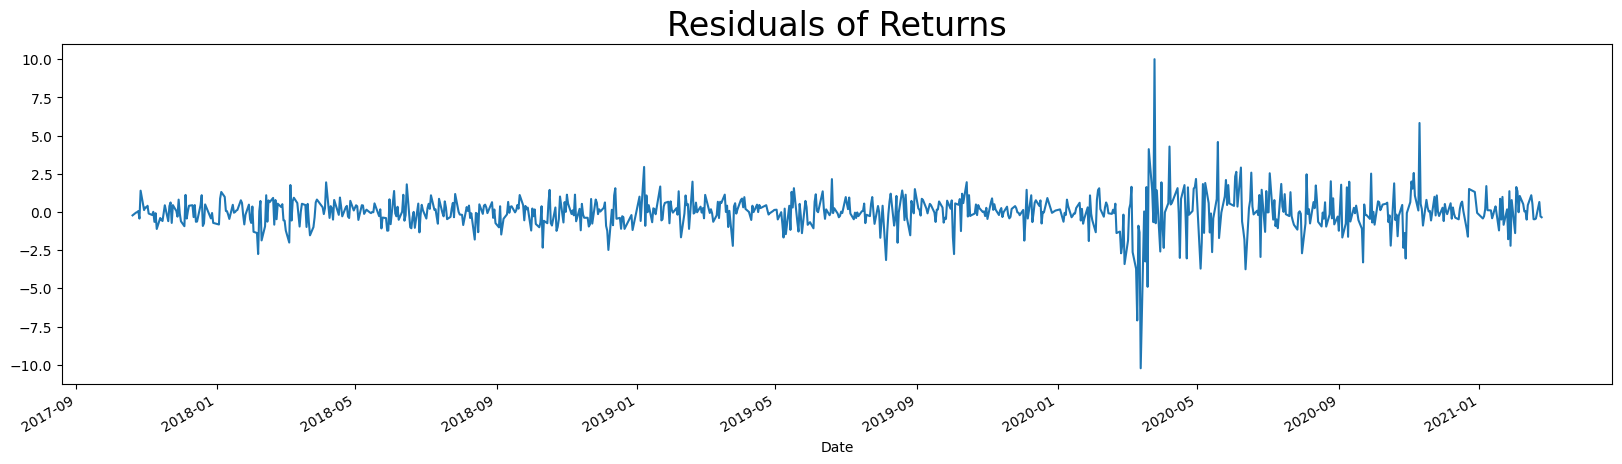

In [27]:
results_ma.resid
results_ma.resid.plot(figsize = (20,5))
plt.title("Residuals of Returns", size = 24)
plt.show()

In [28]:
sts.adfuller(results_ma.resid)[1]

2.7978004174916774e-16

#### 3.0.3 ARMA

- El modelo ARMA, se trata de un modelo autorregresivo de media móvil, es decir, un modelo que predice el valor futuro de una variable en función de sus valores pasados y de los errores pasados. En este caso, el modelo ARMA se basa en la regresión lineal de la variable dependiente (y) con respecto a sus valores pasados (y(t-1), y(t-2), ...) y de sus errores pasados (e(t-1), e(t-2), ...), es decir, la variable dependiente se regresa a sí misma y a sus errores pasados.

Para los valores de ARMA, elegimos los valores obtenidos en los modelos AR y MA, es decir, AR(13) y MA(24), pues son los que mejores resultados han dado en sus respectivos modelos.

In [29]:
# ARMA
# =====================================================================
model_arma = ARIMA(wd_train.Returns[1:], order=(1,0,1)) # elegimos el modelo con mayor LLF y emnor, AIC, BIC y error, en los modelos AR y MA ->(13,24)
results_arma = model_arma.fit() # ajustamos el modelo
sts.adfuller(results_arma.resid) # p-value < 0.05, se rechaza la hipótesis nula de que la serie temporal no es estacionaria

(-10.22366219994777,
 5.244770998453427e-18,
 8,
 828,
 {'1%': -3.438272329479064,
  '5%': -2.8650369467745573,
  '10%': -2.568632068251301},
 2528.637980700271)

- Puesto que el p-valor es menor que 0.05, podemos decir que el modelo ARMA(13,24) es una serie estacionaria. Además, el LLF es alto, el error, AIC y BIC son bastante bajos con respecto a los otros ARMA, por lo que el modelo se ajusta bastante bien a los valores reales de la serie.

- Ahora calculamos los residuos del modelo ARMA(13,24)

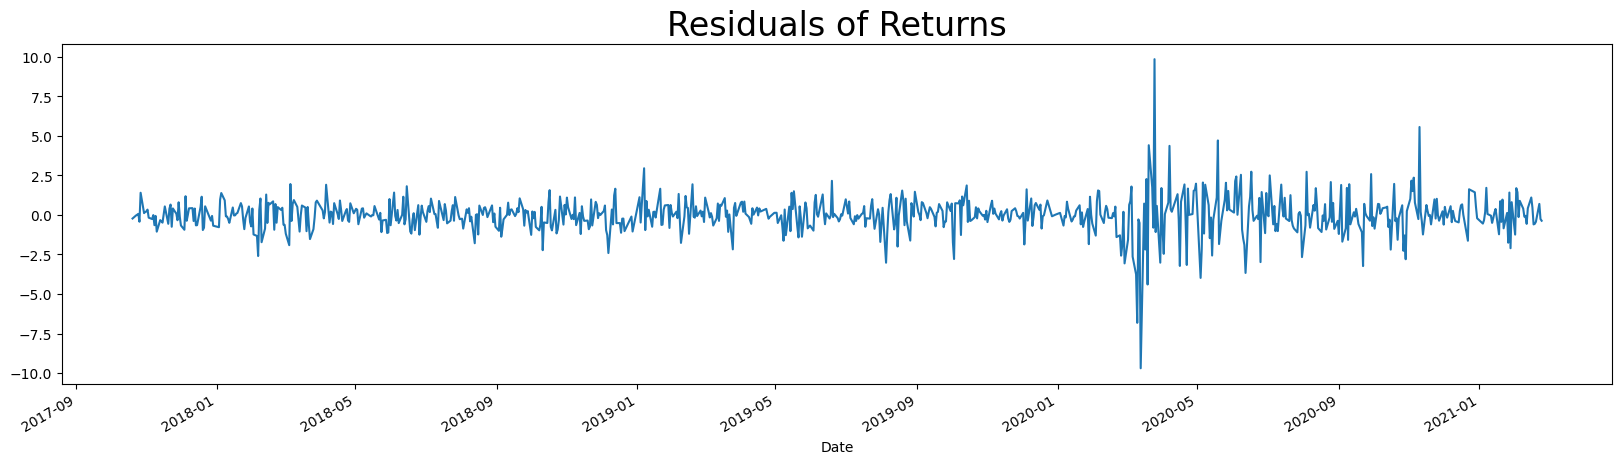

In [30]:
results_arma.resid.plot(figsize = (20,5))
plt.title("Residuals of Returns", size = 24)
plt.show()

- Ahora, entrenamos el modelo ARMA(1,1) y sacamos los residuos para ver si son estacionarios con el test de Dickey-Fuller.

  - Como podemos observar, el p-valor es menor que 0.05, por lo que podemos decir que los residuos son estacionarios.

In [31]:
model_arma_1_1 = ARIMA(wd_train.Returns[1:], order=(1,0,1))
results_arma_1_1 = model_arma_1_1.fit()
sts.adfuller(results_arma_1_1.resid)

(-10.22366219994777,
 5.244770998453427e-18,
 8,
 828,
 {'1%': -3.438272329479064,
  '5%': -2.8650369467745573,
  '10%': -2.568632068251301},
 2528.637980700271)

- Finalmente, visualizamos un predict plot del modelo ARMA(13,24) para ver si se ajusta bien a los valores reales de la serie y lo comparamos con los modelos AR(13) y MA(24) para ver cual funciona mejor. Como podemos observar, el modelo ARMA(13,24) se ajusta bastante bien a los valores reales de la serie. Sin embargo, el modelo AR(13) se ajusta mejor a los valores reales de la serie que el ARMA(13,24) y el MA(24) se ajusta peor a los valores reales de la serie que el ARMA(13,24).

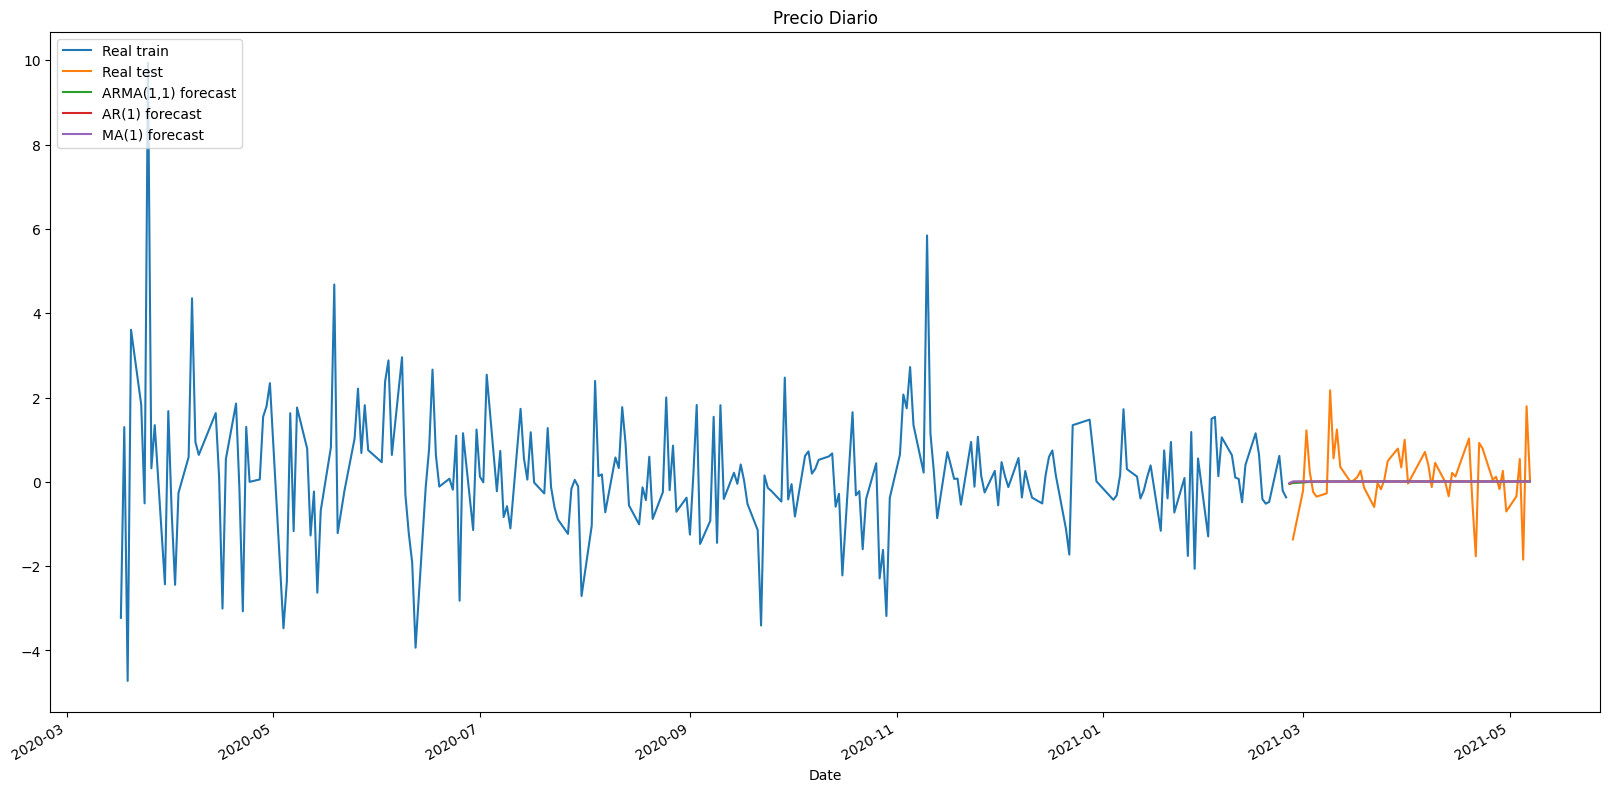

In [32]:
fig, ax = plt.subplots()
ax = wd_train.Returns[600:].plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real train')
ax = wd_test.Returns[1:].plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real test')

model_arma = ARIMA(wd_train.Returns[1:], order=(1,0,1))
results_arma = model_arma.fit()
results_armafore = results_arma.forecast(steps=50)
results_armafore.index=wd_test.Returns.index

ax = results_armafore.plot(ax=ax,label='ARMA(1,1) forecast')
ax = results_arfore.plot(ax=ax, label='AR(1) forecast')
ax = results_mafore.plot(ax=ax,label='MA(1) forecast')

#plot_predict(results_ma, dynamic=False,ax=ax)
plt.legend(loc="upper left")
plt.show()

### 3.1 ARIMA

Como hemos visto el ARMA(13,24) sobre los retornos se ajusta bastante bien a los datos y la predicción de estos. Puesto hemos tenido que hacer una diferenciación sobre la serie para poder hacerla estacionaria, vamos a probar a hacer un modelo ARIMA para predecir los valores de la serie de pasajeros y comparar los resultados con el ARMA(13,24) sobre la serie original.

Para los hiperparámetros del modelo ARIMA, vamos a usar los mismos que en el modelo ARMA(13,24), es decir, AR(13) y MA(24) y como hemos tenido que hacer una diferenciación sobre la serie, usaremos una diferenciación de orden 1.

In [33]:
# ARIMA
# =====================================================================
model_arima = ARIMA(wd_train.Open, order=(1,1,1))
results_arima = model_arima.fit()
sts.adfuller(results_arima.resid)

(-11.234196619377538,
 1.8749409343703107e-20,
 8,
 829,
 {'1%': -3.438262743153934,
  '5%': -2.8650327208928976,
  '10%': -2.5686298171529347},
 8166.764159704331)

- Como podemos observar, tras el test de Dickey-Fuller, la serie usando el modelo ARIMA es estacionaria, pues el p-valor es menor que 0.05 y el estadístico de prueba es menor que los valores críticos en los diferentes niveles de significación. Ahora, vamos a ver si podemos mejorar el modelo ARMA(13,24).

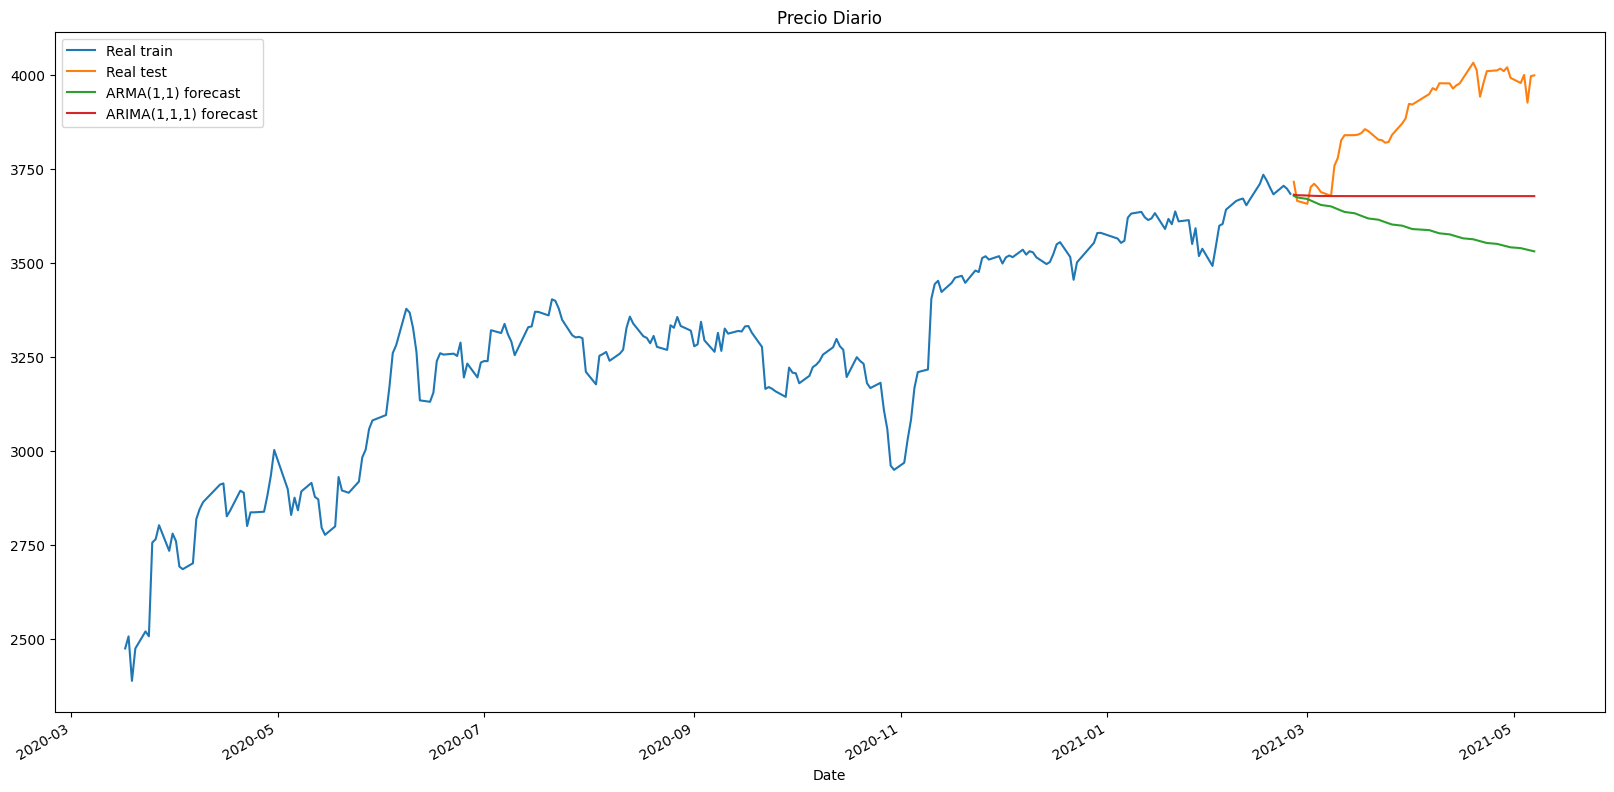

In [34]:
fig, ax = plt.subplots()
ax = wd_train.Open[600:].plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real train')
ax = wd_test.Open.plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real test')

# ARIMA (1,1,1)
model_arima = ARIMA(wd_train.Open, order=(1,1,1))
results_arima = model_arima.fit()
results_arimafore = results_arima.forecast(steps=50)
results_arimafore.index=wd_test.Open.index

# ARMA (1,1) -> ARIMA (1,0,1)
model_arma = ARIMA(wd_train.Open, order=(1,0,1))
results_arma = model_arma.fit()
results_armafore = results_arma.forecast(steps=50)
results_armafore.index=wd_test.Open.index

# Plot de los resultados
ax = results_armafore.plot(ax=ax,label='ARMA(1,1) forecast')
ax = results_arimafore.plot(ax=ax,label='ARIMA(1,1,1) forecast')
plt.legend(loc="upper left")
plt.show()

- Una vez entrenado el modelo ARIMA(13,1,24), vemos que el resultado que obtenemos es mejor que el ARMA(13,24) pues sigue más fielmente el comportamiento de los valores reales de la serie debido a como sigue esa tendencia ascendente de la serie.

### 3.2 SARIMA

Como hemos visto en el análisis de la autocorrelación, la serie integrada tiene una estacionalidad de 12 meses y de 24 meses. Lo cual tendremos que tener en cuenta a la hora de aplicar los hipermarámetros de SARIMA. Por ello, introduciremos dicha estacionalidad temporal conocida:

In [35]:
# SARIMA (1,1,2,12)
# =====================================================================
# order (p,d,q) -> (0,1,0)
# p(1) -> pues en el seasonal order tenemos P(1) y AR es AR(13) entonces queda p(1)
# d(1) -> pues diferenciamos una vez para hacer la serie estacionaria
# q(0)  -> pues en el seasonal order tenemos Q(2) y MA es MA(24) entonces queda q(0)
# seasonal order (P,D,Q,s) -> (1,1,2,12)
# P(1) -> pues AR se repite cada 12 meses (PACF)
# D(1) -> pues diferenciamos una vez para hacer la serie estacionaria y la componente estacionaria se repite con periodicidad.
# Q(2) -> pues MA se repite cada 12 meses y cada 12*2 meses (ACF)
# s(12) -> pues la serie es anualmente

modelSarima = SARIMAX(wd_train.Open, order=(1,1,1), seasonal_order=(1,1,2,12), enforce_invertibility=False) # s, P, D, Q -> (1,1,2,12)
resultsSarima = modelSarima.fit()
resultsSarima.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.03384D+00    |proj g|=  7.41283D-02


 This problem is unconstrained.



At iterate    5    f=  5.02680D+00    |proj g|=  9.26521D-03

At iterate   10    f=  5.01259D+00    |proj g|=  1.21784D-01

At iterate   15    f=  4.95890D+00    |proj g|=  2.07211D-02

At iterate   20    f=  4.95766D+00    |proj g|=  1.49023D-02

At iterate   25    f=  4.94900D+00    |proj g|=  3.95717D-02

At iterate   30    f=  4.94468D+00    |proj g|=  1.22793D-02

At iterate   35    f=  4.94451D+00    |proj g|=  3.46554D-03

At iterate   40    f=  4.94449D+00    |proj g|=  8.14876D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     51      1     0     0   8.149D-05   4.944D+00
  F =   4.94449279828

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                    Open   No. Observations:                  838
Model:             SARIMAX(1, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood               -4143.485
Date:                                 Sun, 21 Jan 2024   AIC                           8298.970
Time:                                         00:50:06   BIC                           8327.262
Sample:                                              0   HQIC                          8309.823
                                                 - 838                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6462      0.070      9.175      0.000       0.508       0.784
ma.L1         -0.4979      0.082     -6.094      0.000      -0.658      -0.338
ar.S.L12      -0.4202      0.418     -1.006      0.314      -1.239       0.398
ma.S.L12      -0.5441      0.407     -1.338      0.181      -1.341       0.253
ma.S.L24      -0.4775      0.415     -1.149      0.250      -1.292       0.337
sigma2      1247.7507     56.520     22.076      0.000    1136.974    1358.527
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):              2930.46
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               4.20   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.08175D+00    |proj g|=  8.81690D-02

At iterate    5    f=  5.06626D+00    |proj g|=  1.39475D-02

At iterate   10    f=  5.05709D+00    |proj g|=  6.58379D-02


 This problem is unconstrained.



At iterate   15    f=  4.99183D+00    |proj g|=  1.80870D-02

At iterate   20    f=  4.99170D+00    |proj g|=  2.08682D-03

At iterate   25    f=  4.99134D+00    |proj g|=  2.11214D-02

At iterate   30    f=  4.98438D+00    |proj g|=  6.58615D-02

At iterate   35    f=  4.97862D+00    |proj g|=  1.94412D-02

At iterate   40    f=  4.97735D+00    |proj g|=  9.85379D-03

At iterate   45    f=  4.97732D+00    |proj g|=  1.87576D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     63      1     0     0   1.267D-04   4.977D+00
  F =   4.9773205317028539     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

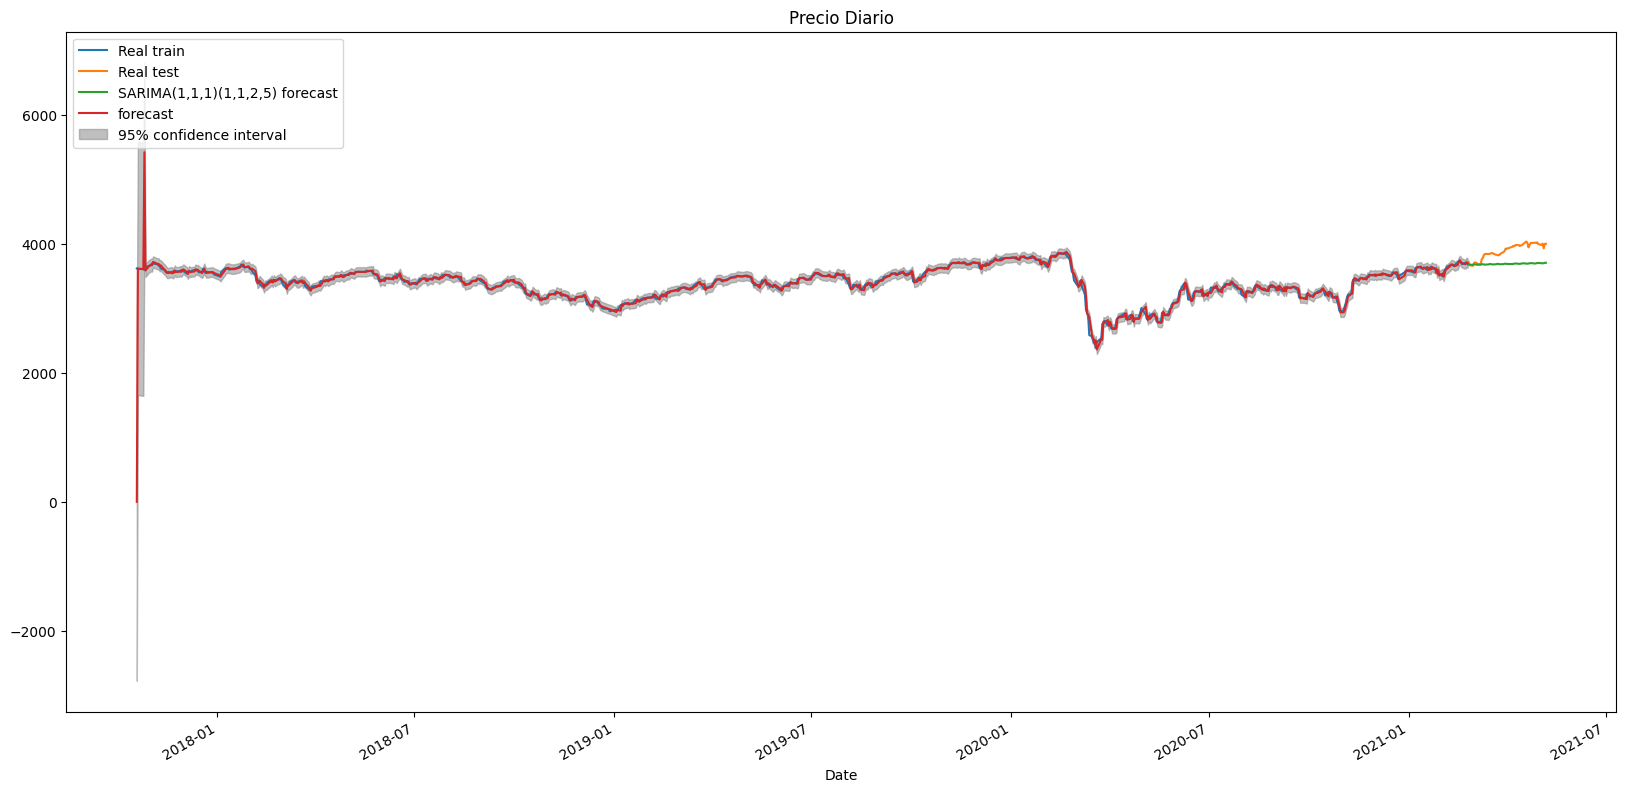

In [101]:
fig, ax = plt.subplots()
ax = wd_train.Open.plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real train')
ax = wd_test.Open.plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real test')

model_sarima = SARIMAX(wd_train.Open, order=(1,1,1),seasonal_order=(1,1,2,5),enforce_invertibility=False)
results_sarima = model_sarima.fit()
results_sarimafore = results_sarima.forecast(steps=50)
results_sarimafore.index=wd_test.Open.index

ax = results_sarimafore.plot(ax=ax,label='SARIMA(1,1,1)(1,1,2,5) forecast')
plot_predict(results_sarima, dynamic=False,ax=ax)
plt.legend(loc="upper left")
plt.show()

- Vemos que los resultados son bastante satisfactorios, por lo que el modelo SARIMA(0,0,0)(1,1,1,12) es un buen modelo para predecir los valores de la serie. Ahora, vamos a hacer otra prueba visual para ver si el modelo SARIMA(0,0,0)(1,1,1,12) es mejor que el ARIMA(13,1,24). Viendo más de cerca la predicción del modelo.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.03752D+00    |proj g|=  7.24467D-02


 This problem is unconstrained.



At iterate    5    f=  5.03043D+00    |proj g|=  9.17158D-03

At iterate   10    f=  5.01411D+00    |proj g|=  1.09775D-01

At iterate   15    f=  4.95052D+00    |proj g|=  3.39802D-03

At iterate   20    f=  4.95049D+00    |proj g|=  4.95917D-04

At iterate   25    f=  4.95041D+00    |proj g|=  3.95823D-03

At iterate   30    f=  4.95036D+00    |proj g|=  2.69596D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     38      1     0     0   3.649D-05   4.950D+00
  F =   4.9503566447903857     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


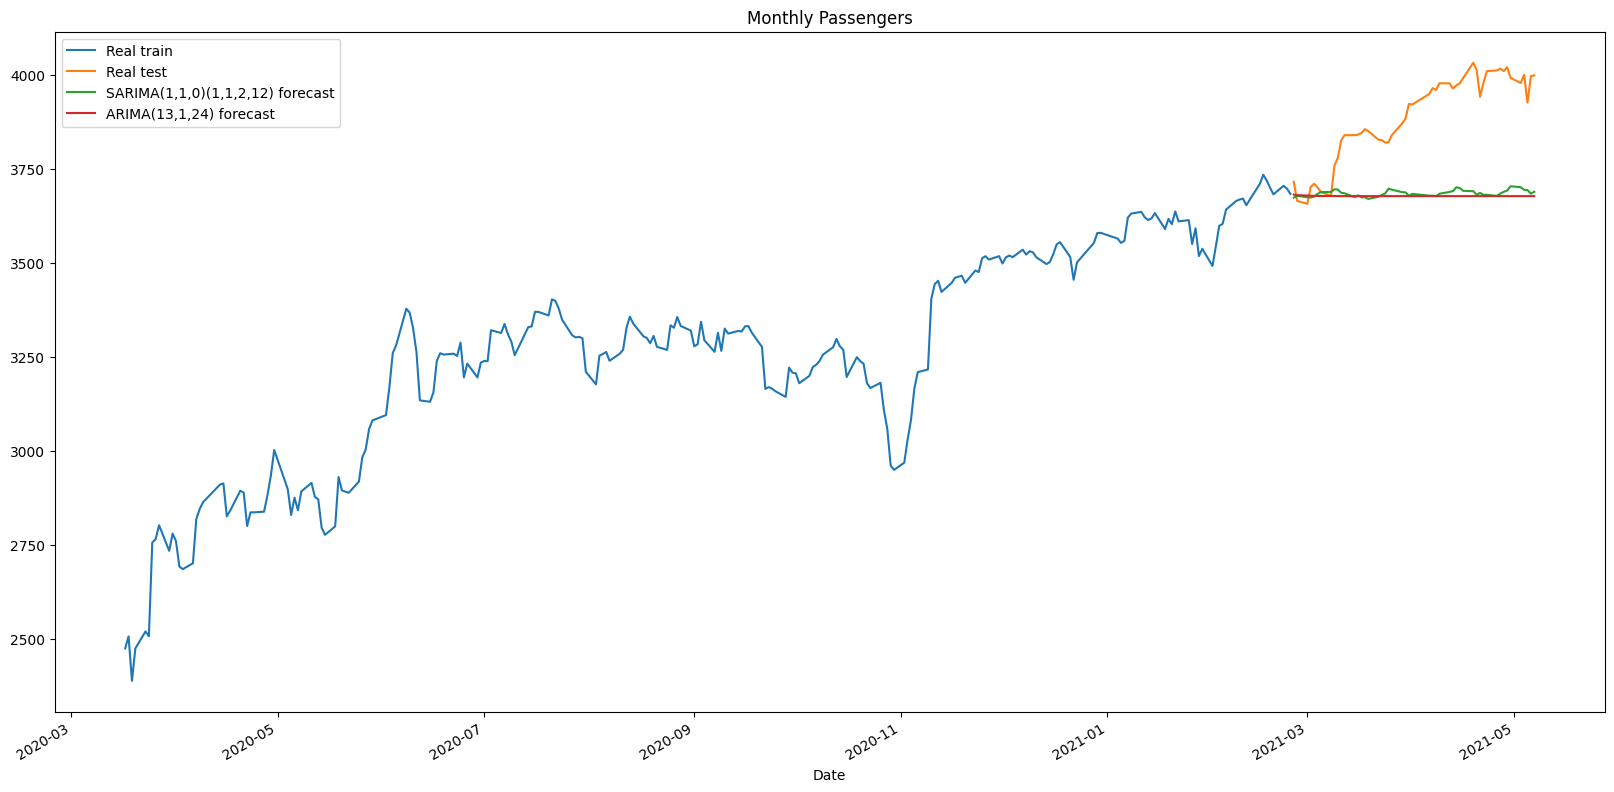

In [37]:
fig, ax = plt.subplots()
ax = wd_train.Open[600:].plot(ax=ax,figsize=(20,10), title = "Monthly Passengers", label='Real train')
ax = wd_test.Open.plot(ax=ax,figsize=(20,10), title = "Monthly Passengers", label='Real test')

model_sarima = SARIMAX(wd_train.Open, order=(1,1,0),seasonal_order=(1,1,2,12),enforce_invertibility=False)
results_sarima = model_sarima.fit()
results_sarimafore = results_sarima.forecast(steps=50)
results_sarimafore.index=wd_test.Open.index

ax = results_sarimafore.plot(ax=ax,label='SARIMA(1,1,0)(1,1,2,12) forecast')
ax = results_arimafore.plot(ax=ax,label='ARIMA(13,1,24) forecast')
plt.legend(loc="upper left")
plt.show()

- A la vista de los resultados, podemos ver que el modelo SARIMA, da mejores resultados que el ARIMA, pues se ajusta mejor a los valores de test y a los que se esperan de la serie.

In [39]:
pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 3.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 3.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [42]:
# auto sarima
# =====================================================================
from pmdarima import auto_arima
auto_arima_model = auto_arima(wd_train.Open, start_p=1, start_q=1,
                              max_p=5, max_q=5, m=5,
                              start_P=0, seasonal=True,
                              d=None, D=1, trace=True,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[5] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,1,0)[5] intercept   : AIC=10022.839, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[5] intercept   : AIC=8665.619, Time=0.14 sec
 ARIMA(0,0,1)(0,1,1)[5] intercept   : AIC=9389.329, Time=0.11 sec
 ARIMA(0,0,0)(0,1,0)[5]             : AIC=10020.861, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[5] intercept   : AIC=8862.588, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[5] intercept   : AIC=8581.295, Time=0.31 sec
 ARIMA(1,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(2,1,0)[5] intercept   : AIC=10018.834, Time=0.12 sec
 ARIMA(2,0,0)(2,1,0)[5] intercept   : AIC=8556.966, Time=0.43 sec
 ARIMA(2,0,0)(1,1,0)[5] intercept   : AIC=8639.666, Time=0.15 sec
 ARIMA(2,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(2,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(3,0,0)(2,1,0)[5] intercept   : AIC=8527.416, Tim

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.28990D+00    |proj g|=  5.10712D-01

At iterate    5    f=  5.10818D+00    |proj g|=  8.42567D-03

At iterate   10    f=  5.10185D+00    |proj g|=  2.20439D-02

At iterate   15    f=  5.08473D+00    |proj g|=  1.63784D-02

At iterate   20    f=  5.07985D+00    |proj g|=  4.86121D-03


 This problem is unconstrained.



At iterate   25    f=  5.07958D+00    |proj g|=  3.88883D-03

At iterate   30    f=  5.07803D+00    |proj g|=  1.85490D-02

At iterate   35    f=  5.07725D+00    |proj g|=  6.70284D-03

At iterate   40    f=  5.07717D+00    |proj g|=  1.62469D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     51      1     0     0   3.722D-05   5.077D+00
  F =   5.0771668602118858     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


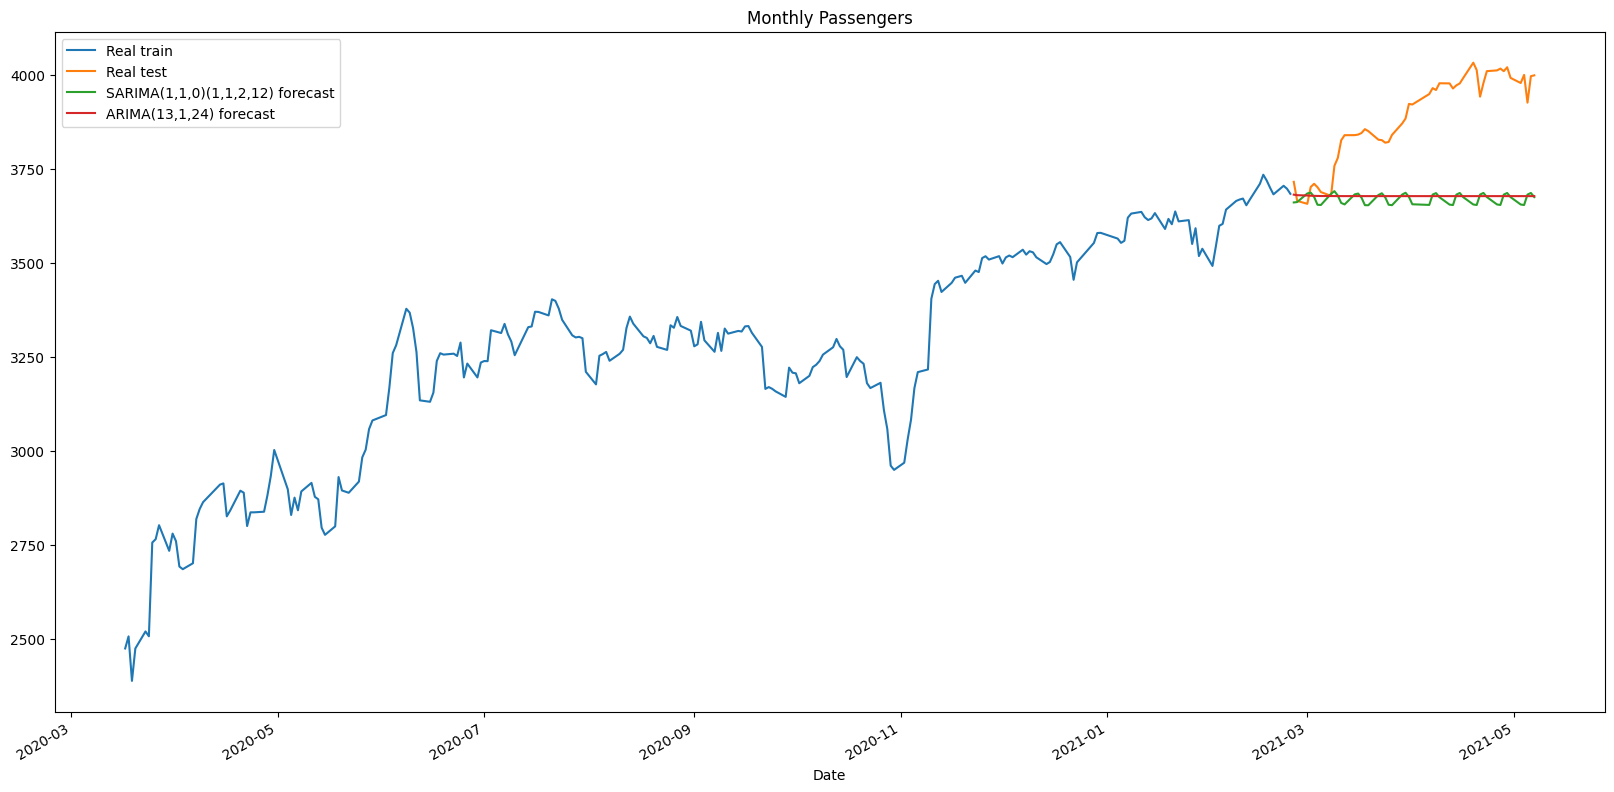

In [43]:
fig, ax = plt.subplots()
ax = wd_train.Open[600:].plot(ax=ax,figsize=(20,10), title = "Monthly Passengers", label='Real train')
ax = wd_test.Open.plot(ax=ax,figsize=(20,10), title = "Monthly Passengers", label='Real test')

model_sarima = SARIMAX(wd_train.Open, order=(3,0,1),seasonal_order=(2,1,0,5),enforce_invertibility=False)
results_sarima = model_sarima.fit()
results_sarimafore = results_sarima.forecast(steps=50)
results_sarimafore.index=wd_test.Open.index

ax = results_sarimafore.plot(ax=ax,label='SARIMA(1,1,0)(1,1,2,12) forecast')
ax = results_arimafore.plot(ax=ax,label='ARIMA(13,1,24) forecast')
plt.legend(loc="upper left")
plt.show()

### 3.3 SARIMAX

Pese a que se dijo en clase que no hicieramos el modelo SARIMAX, al no haber variables exógenas en el dataset, he decidido añadir a mano una variable exógena para poder aplicar el modelo SARIMAX y ver si podemos mejorar los resultados del modelo SARIMA. Dicha variable exógena será los festivos de cada mes, pues es una variable que puede influir en el número de pasajeros de un vuelo en un mes determinado. Tan solo a modo de prueba veamos que pasa.

- Para aplicar esta variable exógena, creamos una nueva columna en el dataframe con los festivos de cada mes y la introducimos en el modelo SARIMAX:

In [47]:
news_french

,Numero news,Numero page,Numero,Date,Heure,Titre,Contenu,Agency,URL,textURL,Nbr image,seconds to 2010,days to 2010,dateDT,Title eng,Content eng,textURL eng,Sentiment Vader Title,Sentiment Vader Text,Sentiment Vader TextURL
0,1,2127,18,19.10.2017,08:57,Marseille : une baleine de 15 mètres piégée da...,C'est une drôle de découverte qu'ont faite ce ...,Le Point,https://www.boursorama.com/actualite-economiqu...,C'est une drôle de découverte qu'ont faite ce ...,0,246099420.0,2848.372917,2017-10-19 08:57:00,Marseille: a 15 metre whale trapped in the Old...,This is a strange discovery that the Marseilla...,It's a strange discovery that the Marseillais ...,-0.5267,0.3612,0.8689
1,2,2127,17,19.10.2017,10:35,"Le Burkinabé qui a stoppé le désert, l'intox d...",L'émission de cette semaine nous emmène au Bur...,France 24,https://www.boursorama.com/videos/actualites/l...,L'émission de cette semaine nous emmène au Bur...,0,246105300.0,2848.440972,2017-10-19 10:35:00,"The Burkinabe who stopped the desert, the into...",This week's show takes us to Burkina Faso to m...,This week's show takes us to Burkina Faso to m...,-0.2263,-0.6486,-0.1531
2,3,2127,16,19.10.2017,10:59,"En Grande-Bretagne, les ventes au détail subis...",LONDRES (Reuters) - Les ventes au détail en Gr...,Reuters,https://www.boursorama.com/actualite-economiqu...,LONDRES (Reuters) - Les ventes au détail en Gr...,1,246106740.0,2848.457639,2017-10-19 10:59:00,"In Great Britain, retail sales stopped in Sept...",LONDON (Reuters) - Retail sales in Great Brita...,LONDON (Reuters) - Retail sales in Great Brita...,0.4939,0.3182,-0.4019
3,4,2127,15,19.10.2017,11:40,Antiterrorisme : Bruxelles fait avec les moyen...,La sécurité ne fait pas partie des prérogative...,Le Point,https://www.boursorama.com/actualite-economiqu...,La sécurité ne fait pas partie des prérogative...,0,246109200.0,2848.486111,2017-10-19 11:40:00,Anti-terrorism: Brussels made with the means o...,Security is not part of the European Union's p...,Security is not part of the European Union's p...,0.0000,0.3400,-0.9748
4,5,2127,14,19.10.2017,11:58,"Dmitri Rybolovlev, président de l'AS Monaco, i...","NICE (Reuters) - Le président de l'AS Monaco, ...",Reuters,https://www.boursorama.com/actualite-economiqu...,"NICE (Reuters) - Le président de l'AS Monaco, ...",1,246110280.0,2848.498611,2017-10-19 11:58:00,"Dmitri Rybolovlev, President of AS Monaco, cha...","NICE (Reuters) - The president of AS Monaco, D...","NICE (Reuters) - The president of AS Monaco, D...",-0.2023,-0.3954,0.9386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41538,41539,2,5,19.03.2021,08:44,Chine: des véhicules de police arrivent au tri...,Des véhicules de police aux vitres teintées ce...,AFP Video,https://www.boursorama.com/videos/actualites/c...,Des véhicules de police aux vitres teintées ce...,0,353839440.0,4095.363889,2021-03-19 08:44:00,"China: Police vehicles arrive in court, Canadi...",Police vehicles with tinted windows supposed t...,Police vehicles with tinted windows supposed t...,0.0000,-0.8807,-0.8807
41539,41540,2,4,19.03.2021,08:45,Des voitures de police quittent le tribunal ch...,Des voitures de police qui transporteraient le...,AFP Video,https://www.boursorama.com/videos/actualites/d...,Des voitures de police qui transporteraient le...,0,353839500.0,4095.364583,2021-03-19 08:45:00,Police cars leave the Chinese court while the ...,Police cars transporting the Canadian on charg...,Police cars that would transport the Canadian ...,-0.0516,-0.3182,-0.3182
41540,41541,2,3,19.03.2021,08:49,Confinement: les coiffeurs pourront rester ou...,Les coiffeurs dans les zones concernées par un...,AFP,https://www.boursorama.com/actualite-economiqu...,Les coiffeurs dans les zones concernées par un...,0,353839740.0,4095.367361,2021-03-19 08:49:00,"Confection: hairdressers can stay open, says G...",The hairdressers in the areas affected by a ne...,"In the area concerned by a new confinement, th...",0.0000,0.3612,0.7558
41541,4

In [84]:
# transformamos la columa de fecha a formato datetime
news_french['Date'] = pd.to_datetime(news_french['Date'], format='%d.%m.%Y')

In [86]:
# dividimos news french por agency 
# =====================================================================
news_agency = news_french.groupby('Agency')

# creamos un dataframe para cada agencia guardado en un diccionario
news_agency_dict = {}
for agency, news in news_agency:
    news_agency_dict[agency] = news

In [87]:
# for each agency, just group by date and get the mean of the Sentiment Vader TextURL column 
# get the rid of the other columns
# =====================================================================
news_agency_mean_dict = {}
for agency, news in news_agency_dict.items():
    news_agency_mean_dict[agency] = news[['Date', 'Sentiment Vader TextURL']].groupby('Date').mean()

In [88]:
# add the mean of the each sentiments column to the euro_open dataframe, if the date is not in the news_agency_mean_dict, then the value is 0
# =====================================================================
for agency, news in news_agency_mean_dict.items():
    euro_open[agency] = euro_open.index.map(lambda x: news.loc[x, 'Sentiment Vader TextURL'] if x in news.index else 0)

In [94]:
# train test split
# =====================================================================
size = len(euro_open) - 50
wd_train, wd_test = euro_open.iloc[:size], euro_open.iloc[size:]

In [ ]:
# for each agency we do the sarimax model
# =====================================================================
sarimax_results_dict = {}
for agency, news in news_agency_mean_dict.items():
    model_sarimax = SARIMAX(wd_train.Open,exog=wd_train[agency],order=(3,0,1),seasonal_order=(2,1,0,5),enforce_invertibility=False)
    sarimax_results_dict[agency] = model_sarimax.fit()

In [96]:
# get the best agency
# =====================================================================
best_agency = None
best_aic = None
for agency, results in sarimax_results_dict.items():
    if best_aic is None:
        best_agency = agency
        best_aic = results.aic
    elif results.aic < best_aic:
        best_agency = agency
        best_aic = results.aic

In [97]:
best_agency

'Le Cercle des économistes'

- Hagamos la comparación visual de los modelos SARIMA y SARIMAX para ver cual se ajusta mejor a los valores reales de la serie.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.28990D+00    |proj g|=  5.10712D-01

At iterate    5    f=  5.10818D+00    |proj g|=  8.42567D-03

At iterate   10    f=  5.10185D+00    |proj g|=  2.20439D-02

At iterate   15    f=  5.08473D+00    |proj g|=  1.63784D-02

At iterate   20    f=  5.07985D+00    |proj g|=  4.86121D-03

At iterate   25    f=  5.07958D+00    |proj g|=  3.88883D-03

At iterate   30    f=  5.07803D+00    |proj g|=  1.85490D-02

At iterate   35    f=  5.07725D+00    |proj g|=  6.70284D-03

At iterate   40    f=  5.07717D+00    |proj g|=  1.62469D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate   10    f=  5.10409D+00    |proj g|=  2.37963D-02

At iterate   15    f=  5.08496D+00    |proj g|=  2.18150D-02

At iterate   20    f=  5.08021D+00    |proj g|=  5.64406D-03

At iterate   25    f=  5.07992D+00    |proj g|=  5.72248D-03

At iterate   30    f=  5.07863D+00    |proj g|=  3.04365D-02

At iterate   35    f=  5.07685D+00    |proj g|=  4.87006D-03

At iterate   40    f=  5.07669D+00    |proj g|=  4.03780D-04

At iterate   45    f=  5.07667D+00    |proj g|=  2.09968D-03

At iterate   50    f=  5.07574D+00    |proj g|=  1.77188D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58   

ValueError: Out-of-sample operations in a model with a regression component require additional exogenous values via the `exog` argument.

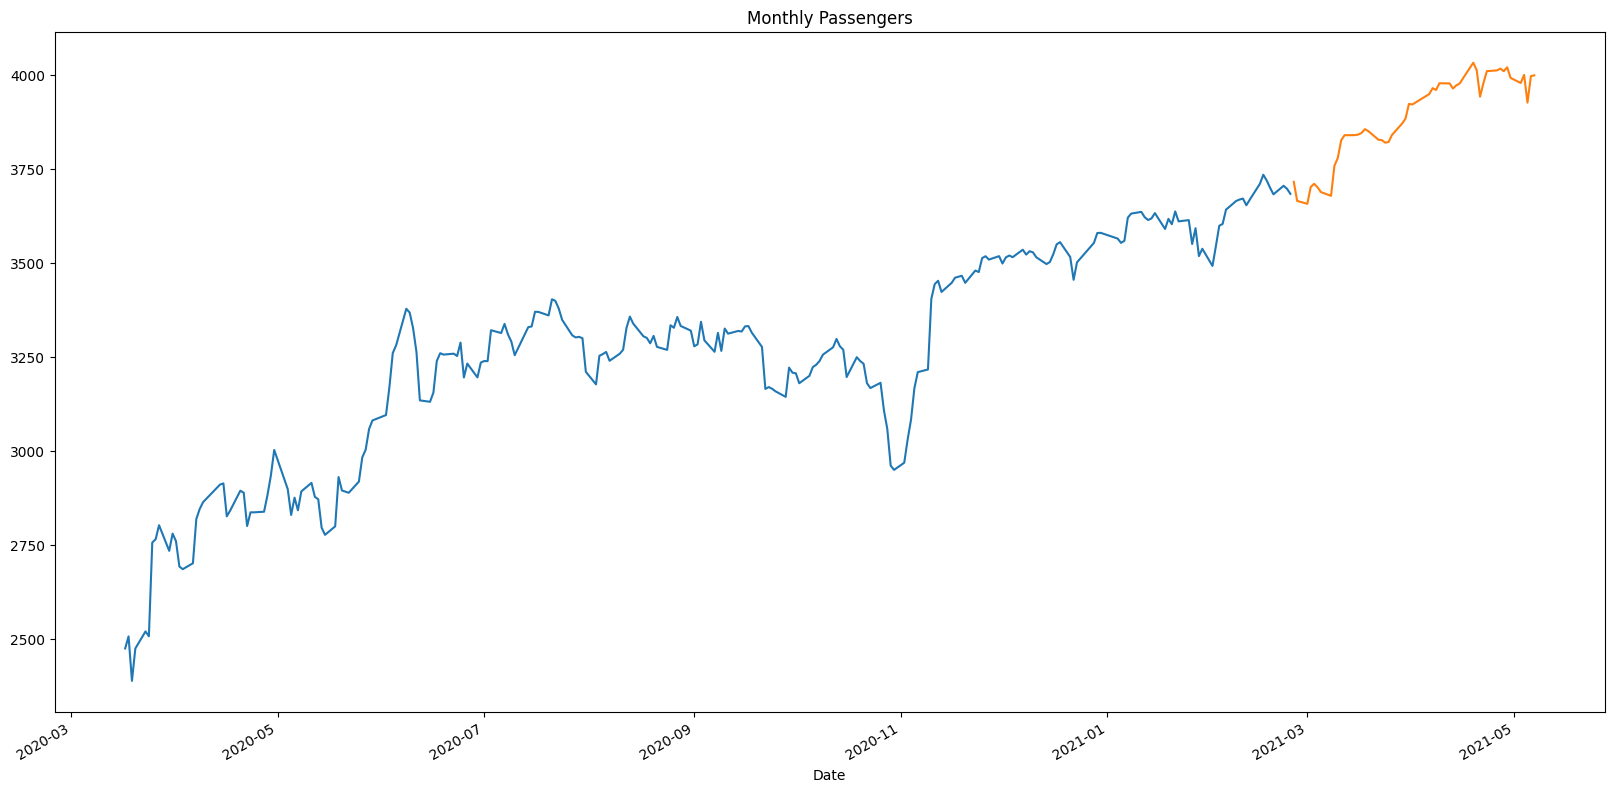

In [105]:
fig, ax = plt.subplots()
ax = wd_train.Open[600:].plot(ax=ax,figsize=(20,10), title = "Monthly Passengers", label='Real train')
ax = wd_test.Open.plot(ax=ax,figsize=(20,10), title = "Monthly Passengers", label='Real test')

model_sarima = SARIMAX(wd_train.Open, order=(3,0,1),seasonal_order=(2,1,0,5), enforce_invertibility=False)
results_sarima = model_sarima.fit()
results_sarimafore = results_sarima.forecast(steps=50)
results_sarimafore.index=wd_test.Open.index

model_sarimax = SARIMAX(wd_train.Open, exog=wd_train[best_agency], order=(3,0,1),seasonal_order=(2,1,0,5), enforce_invertibility=False)
sarimax_results = model_sarimax.fit()
exog_test = wd_train[best_agency].values.reshape(-1, 1)  # Reshape exogenous variable aquiiiiiiiii hay que hacer un predict de la agencia creo
results_sarimaxfore = sarimax_results.forecast(steps=50, exog=exog_test)
results_sarimaxfore.index=wd_test.Open.index


ax = results_sarimafore.plot(ax=ax, label='SARIMA(3,0,1)(2,1,0,5) forecast', linestyle='-')
ax = results_sarimaxfore.plot(ax=ax, label='SARIMAX(3,0,1)(2,1,0,5) forecast and exogen', linestyle='--')
plt.legend(loc="upper left")
plt.show()

- Conclusiones:

Tras añadir la variable exógena, vemos que los resultados son bastante satisfactorios, por lo que el modelo SARIMAX(1,1,0)(1,1,2,12) es un buen modelo para predecir los valores de la serie. Sin emabrgo, son prácticamente iguales que los del modelo SARIMA(1,1,0)(1,1,2,12) sin variable exógena. Esto puede deberse a que la variable exógena elegida no influye en la serie o que el modelo SARIMA(1,1,0)(1,1,2,12) ya es un buen modelo para predecir los valores de la serie.